Explorative Data Analysis for Kaggle House Price prediction
===============

This notebook contains charts I made during the explorative analysis of the data. It serves as a form of documentation and substantiates the transformations made in the `Model` notebook.

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from utils import data_profile, hist_compare

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
COL_Y = 'SalePrice'

# Load data

In [149]:
df_train = pd.read_csv('data/train.csv', index_col='Id')
df_test = pd.read_csv('data/test.csv', index_col='Id')
df = pd.concat((df_train, df_test))

print("n:", len(df), "n_cols: ", len(df.columns))

n: 2919 n_cols:  80


# High level overview

In [150]:
df.dtypes.value_counts()

object     43
int64      25
float64    12
dtype: int64

In [151]:
def cols_of_dtype(df, dtype):
    return sorted([c for c in df.columns if df[c].dtype == dtype])

In [152]:
for dtype in df.dtypes.value_counts().index:
    print("-> Dtype: ", dtype)
    print(repr(cols_of_dtype(df, dtype)))
    print("-----")

-> Dtype:  object
['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']
-----
-> Dtype:  int64
['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LowQualFinSF', 'MSSubClass', 'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']
-----
-> Dtype:  float64
['BsmtFinSF1'

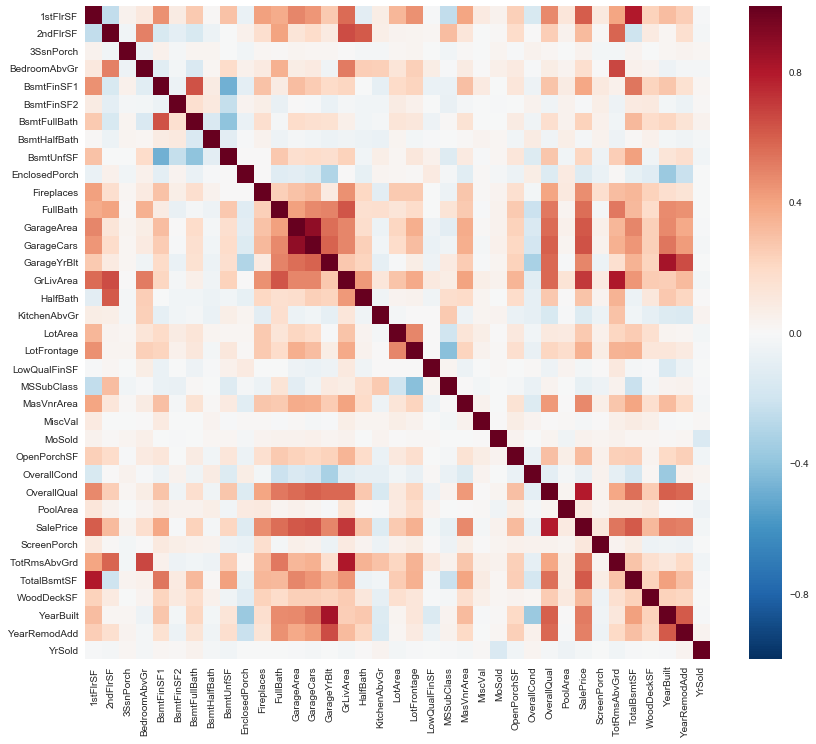

In [153]:
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr())

Some immediate observations:
- Vars strongly correlated with SalePrice are: `1stFlrSF`, `FullBath`, `GarageArea`, `GarageCars`, `GrLivArea`, `OverallQual`, `TotalBsmtSF`.
- There also is some collinearity between e.g. `GarageArea` and `GarageCars`. Which makes total sense, the bigger it is the more cars fit inside. I'm not going to worry a lot about this though, because I'm not concerned with stability of coefficients, only with good predictions. But it might make sense to keep only one of the two.
- Some vars have almost no correlation, e.g. `MoSold` and `YrSold`. Looks like we can safely drop these, but we might be able to extract some value out of them before dropping them.
- There isn't any substantial negative correlation between `SalePrice` and any other variable, so we can focus on positive correlations.

Zoom in a bit on highly (positively) correlated vars:

In [154]:
high_corr = df.corr()[COL_Y].sort_values(ascending=False).head(15)

In [155]:
print(high_corr)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


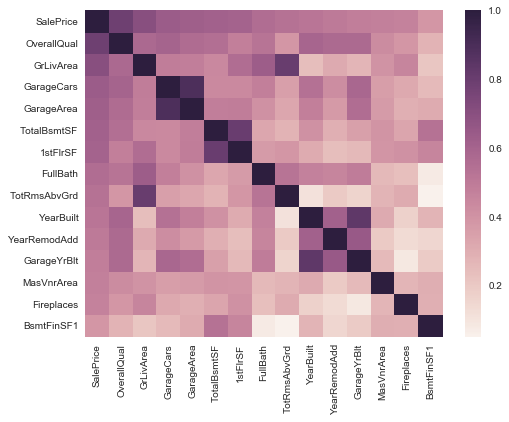

In [156]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[high_corr.index.tolist()].corr());

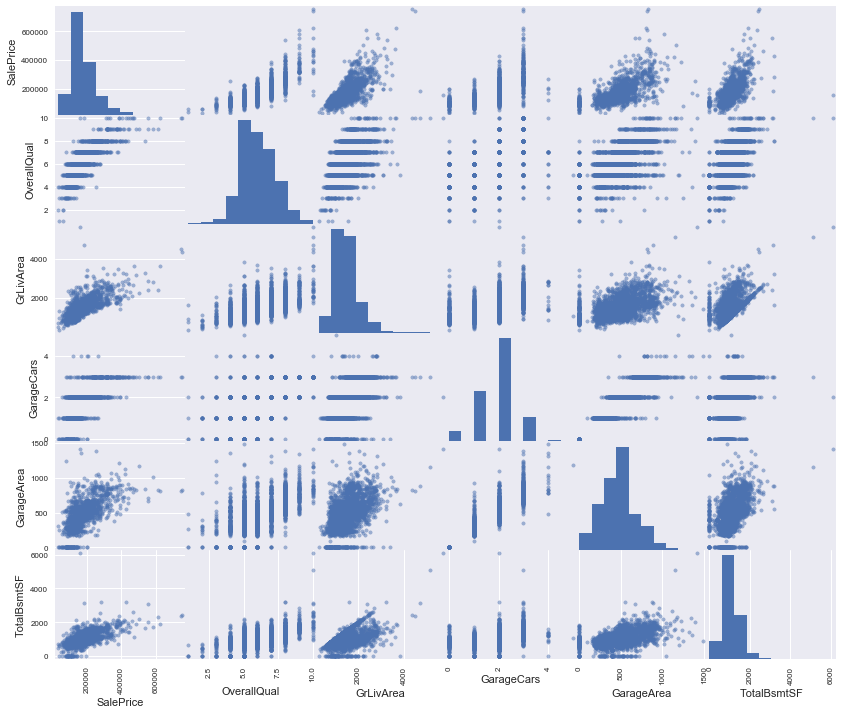

In [157]:
pd.scatter_matrix(df[high_corr[:6].index.tolist()], figsize=(14,12));

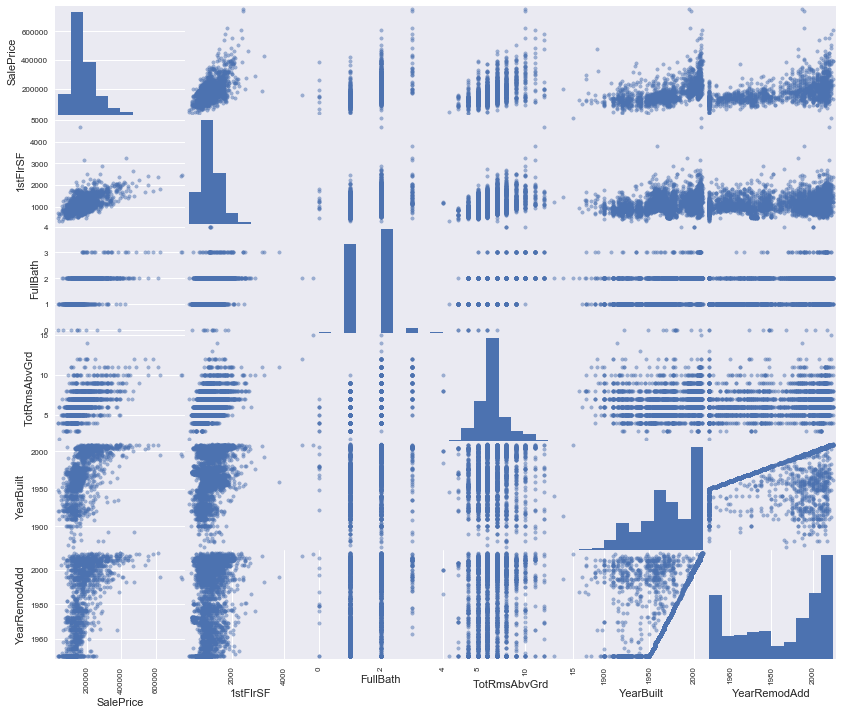

In [158]:
pd.scatter_matrix(df[[COL_Y] + high_corr[6:11].index.tolist()], figsize=(14,12));

Observations:
- I see a couple of approximately linear relations, e.g. `SalePrice` and `GrLivArea` (as we would expect, given the filter on highly correlated vars)
- Distributions don't look normal. Right skews could warrant a log/sqrt transformation. Will look into this later.
- Should be wary for outliers. E.g. `GrLivArea` shows 2 big houses with pretty low Sale Price. Will looko into this later as well.
- Interesting structure between `GrLivArea` and `TotalBsmtSF`. I guess it's pretty rare to have a basement that's bigger than the living room. I expect the same with `1srFlrSF` and `GrLivArea` (although it's not in this plot, might check this out in more detail below).
- Recently built houses seem a bit more expensive. There's also more of them. Recently remodeled houses may also be more expensive but it's difficult to see. These `Year` distributions seem difficult to deal with. See `YearRemodAdd`; there's a big peak at around 1950. Looks like some sort of default value. Will consider doing something about this.

Ok, these were the important numeric fields. I have some ideas on what to look out for later. Will check categorical fields one by one below.

# Detailed inspections
The order here roughly corresponds with the transformations in the `Model` notebook.

### SalePrice
The scatterplot matrix showed that SalePrice is right-skewed. I'm not 100% sure on the theory here because I've only ever seen it being done on the dependent variables, but I have a feeling that it'll help. Crossvalidation confirmed it later on.

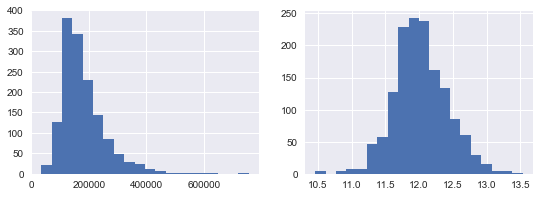

In [159]:
_, (l, r) = plt.subplots(ncols=2, figsize=(9, 3))
l.hist(df['SalePrice'].dropna().values, bins=20);
r.hist(np.log(df['SalePrice'].dropna().values), bins=20);

### Alley

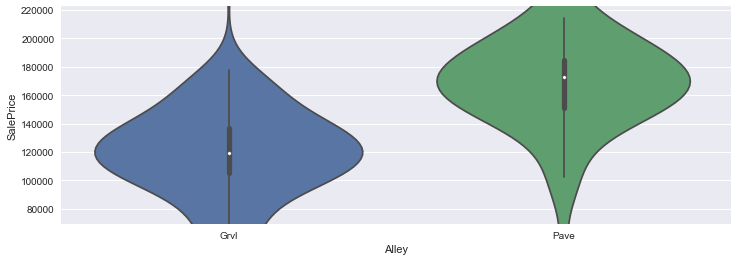

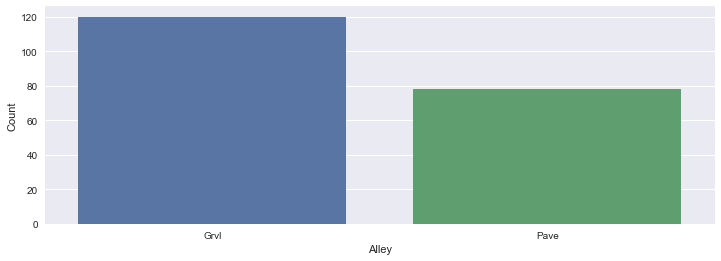

2721  missing entries


In [160]:
data_profile(df, 'Alley')

A lot of missing values - probably best to delete it.

#### Utilities

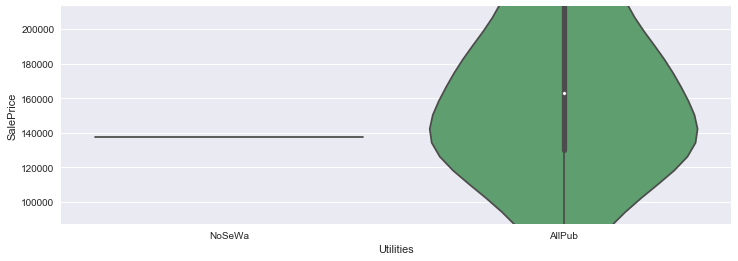

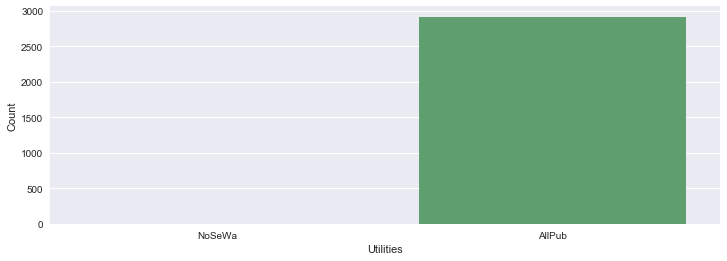

2  missing entries


In [161]:
data_profile(df, 'Utilities')

Only 1 house with NoSeWa? Let's drop it. 

### Basement

According to the description, if one of ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] is missing, there is no basement. But in a lot of cases only BsmtCond is missing or only BsmtExposure. So we can't just conclude that there is no basement by just looking at 1 of the fields.

In [162]:
bsmt_cols = [c for c in df.columns if 'Bsmt' in c]
bsmt_cols_num = [c for c in bsmt_cols if df[c].dtype != 'object']
bsmt_cols_cat = set(bsmt_cols) - set(bsmt_cols_num)
print("  All:", bsmt_cols)
print("  Numeric: ", bsmt_cols_num)
print("  Cat: ", bsmt_cols_cat)

df_nobsmt = df[(df['BsmtCond'].isnull()) | 
                (df['BsmtQual'].isnull()) | 
                df['BsmtExposure'].isnull() | 
                df['BsmtFinType1'].isnull() |
                df['BsmtFinType2'].isnull()
              ][bsmt_cols]
len(df_nobsmt)

  All: ['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'TotalBsmtSF']
  Numeric:  ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF']
  Cat:  {'BsmtFinType2', 'BsmtCond', 'BsmtFinType1', 'BsmtQual', 'BsmtExposure'}


88

Assumption: if both quality and condition are missing, the property has no basement.

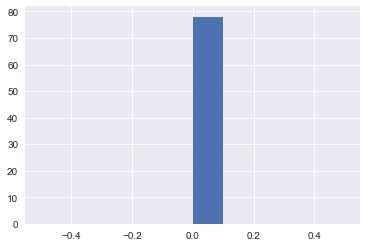

In [163]:
df[(df['BsmtQual'].isnull()) & (df['BsmtCond'].isnull())]['TotalBsmtSF'].hist()

79


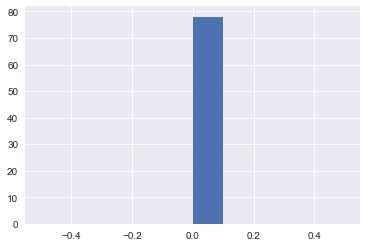

In [164]:
df_nobsmt = df[(df['BsmtQual'].isnull()) & (df['BsmtCond'].isnull())][bsmt_cols]
print(len(df_nobsmt))
df_nobsmt['TotalBsmtSF'].hist();

Looks like this assumption made sense.

In [165]:
print(len(df[(df['TotalBsmtSF'] == 0)]))
print(len(df[(df['TotalBsmtSF'] == 0) | (df['TotalBsmtSF'].isnull())]))

78
79


Only one with NaN TotalBsmtSF.

In [166]:
df_comb = df.copy()

In [167]:
df_comb.loc[(df_comb['BsmtQual'].isnull()) & (df_comb['BsmtCond'].isnull()), bsmt_cols_cat] = 'NoBsmt'

# 2 rows have NaNs in one of these numeric columns:
cond_numnull = False
for col in bsmt_cols_num:
    cond_numnull = cond_numnull | (df_comb[col].isnull())
df_comb.loc[(df_comb['BsmtCond'] == 'NoBsmt') & cond_numnull, bsmt_cols_num]

BsmtFinSF1  BsmtFinSF2  BsmtFullBath  BsmtHalfBath  BsmtUnfSF  \
Id                                                                    
2121         NaN         NaN           NaN           NaN        NaN   
2189         0.0         0.0           NaN           NaN        0.0   

      TotalBsmtSF  
Id                 
2121          NaN  
2189          0.0

In [168]:
df_comb.loc[(df_comb['BsmtCond'] == 'NoBsmt'), bsmt_cols_num] = 0

In [169]:
for col in bsmt_cols:
    df_bsmt_with_null = df_comb.loc[(df_comb['BsmtQual'] != 'NoBsmt') & (df_comb[col]).isnull()]
    if len(df_bsmt_with_null) > 0:
        print("Col {} has {} missing values".format(col, len(df_bsmt_with_null)))

Col BsmtCond has 3 missing values
Col BsmtExposure has 3 missing values
Col BsmtFinType2 has 1 missing values
Col BsmtQual has 2 missing values


In [170]:
cond_null = False
for col in bsmt_cols:
    cond_null = cond_null | (df_comb[col].isnull())

df_comb.loc[cond_null, bsmt_cols]
#df_comb.loc[(df_comb[cond_null]), :]

BsmtCond BsmtExposure  BsmtFinSF1  BsmtFinSF2 BsmtFinType1 BsmtFinType2  \
Id                                                                             
333        TA           No      1124.0       479.0          GLQ          NaN   
949        TA          NaN         0.0         0.0          Unf          Unf   
1488       TA          NaN         0.0         0.0          Unf          Unf   
2041      NaN           Mn      1044.0       382.0          GLQ          Rec   
2186      NaN           No      1033.0         0.0          BLQ          Unf   
2218       Fa           No         0.0         0.0          Unf          Unf   
2219       TA           No         0.0         0.0          Unf          Unf   
2349       TA          NaN         0.0         0.0          Unf          Unf   
2525      NaN           Av       755.0         0.0          ALQ          Unf   

      BsmtFullBath  BsmtHalfBath BsmtQual  BsmtUnfSF  TotalBsmtSF  
Id                                                                 
333            1.0           0.0       Gd     1603.0       3206.0  
949            0.0           0.0       Gd      936.0        936.0  
1488           0.0           0.0       Gd     1595.0       1595.0  
2041           1.0           0.0       Gd        0.0       1426.0  
2186           0.0           1.0       TA       94.0       1127.0  
2218           0.0           0.0      NaN      173.0        173.0  
2219           0.0           0.0      NaN      356.0        356.0  
2349           0.0           0.0       Gd      725.0        725.0  
2525           0.0           0.0       TA      240.0        995.0

I think it's fair to just let these missing values get imputed. Let's look at the square feet numbers.

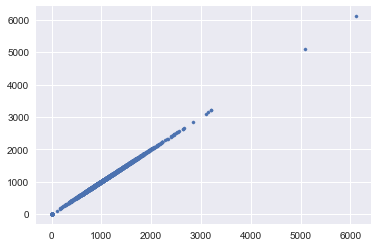

In [171]:
plt.scatter(df_comb['TotalBsmtSF'], df_comb['BsmtFinSF1'] + df_comb['BsmtFinSF2'] + df_comb['BsmtUnfSF'], s=10)

Perfectly linear. I was expecting some mistakes. Those outliers might need some looking into (will do that later).

### Garage

In [172]:
gar_cols = {c for c in df.columns if 'garage' in c.lower()}
gar_cols_num = {c for c in gar_cols if df[c].dtype != 'object'}
gar_cols_cat = gar_cols - gar_cols_num
# I don't really know what's best for missing values in GarageYrBlt. Will let KNN impute something:
gar_cols_num.remove('GarageYrBlt')  
print(gar_cols)
print(gar_cols_num)
print(gar_cols_cat)

{'GarageCond', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageYrBlt', 'GarageArea', 'GarageQual'}
{'GarageCars', 'GarageArea'}
{'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual'}


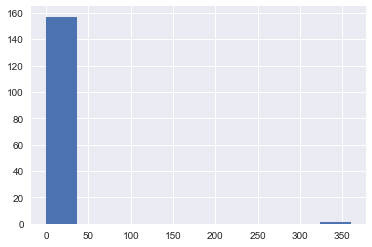

In [173]:
df.loc[(df['GarageCond']).isnull() & (df['GarageQual'].isnull()), gar_cols]['GarageArea'].hist()

Ok, so in contrast to Basement, Cond & Qual null contains something with a non-null area.

In [174]:
df.loc[df['GarageArea'].isnull()][list(gar_cols)]

GarageCond GarageType GarageFinish  GarageCars  GarageYrBlt  GarageArea  \
Id                                                                             
2577        NaN     Detchd          NaN         NaN          NaN         NaN   

     GarageQual  
Id               
2577        NaN

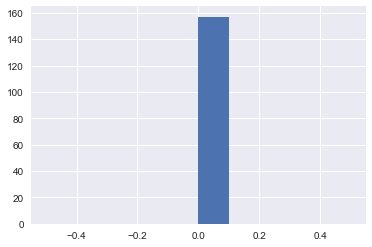

In [175]:
df.loc[df['GarageArea'] == 0][list(gar_cols)]['GarageCars'].hist()

Ok, so it's better to select on GarageArea is 0 or null. Aassuming that the one record with GarageType = 'Detchd' but everything else missing does not have a garage.

In [176]:
df_comb = df.copy()
cond_nogar = (df_comb['GarageArea'] == 0) | (df_comb['GarageArea'].isnull())
df_comb.loc[cond_nogar, gar_cols_cat] = 'NoGarage'
df_comb.loc[cond_nogar, gar_cols_num] = 0

In [177]:
df_comb[df_comb['GarageYrBlt'].isnull()][list(gar_cols)].head()

GarageCond GarageType GarageFinish  GarageCars  GarageYrBlt  GarageArea  \
Id                                                                           
40   NoGarage   NoGarage     NoGarage         0.0          NaN         0.0   
49   NoGarage   NoGarage     NoGarage         0.0          NaN         0.0   
79   NoGarage   NoGarage     NoGarage         0.0          NaN         0.0   
89   NoGarage   NoGarage     NoGarage         0.0          NaN         0.0   
90   NoGarage   NoGarage     NoGarage         0.0          NaN         0.0   

   GarageQual  
Id             
40   NoGarage  
49   NoGarage  
79   NoGarage  
89   NoGarage  
90   NoGarage

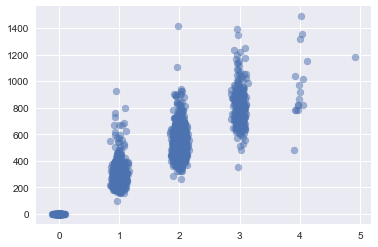

In [178]:
plt.scatter(df_comb['GarageCars'] + np.random.randn(len(df_comb)) * .05, 
            df_comb['GarageArea'], alpha=.5)

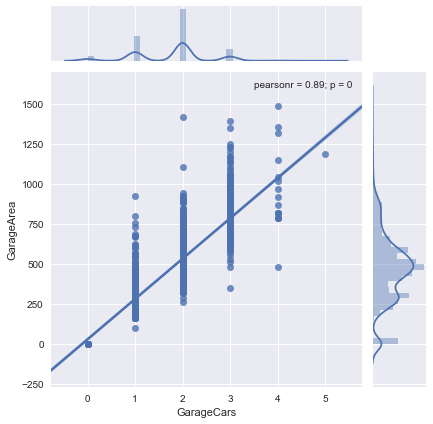

In [179]:
sns.jointplot('GarageCars', 'GarageArea', df_comb, kind='reg')

### MSSubClass

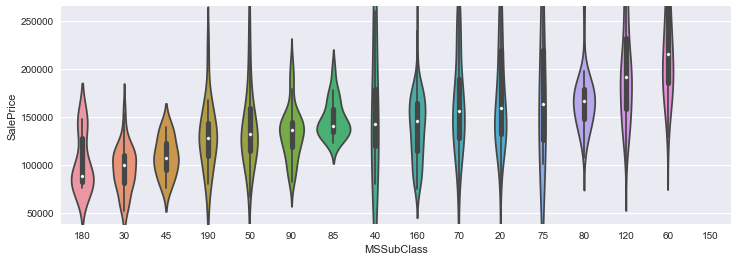

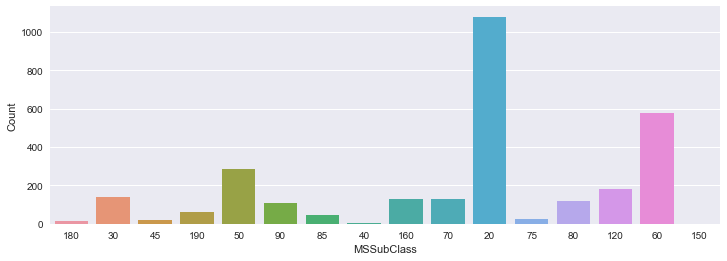

0  missing entries


In [180]:
data_profile(df, 'MSSubClass', dtype='cat')

Let's also combine some MSSubClass'es that are close together, have a simular distribution, but only have few examples: 
- 40 and 160
- 70, 20, 75
- 190, 50, 90
- 30, 34, 180

Oh, there's only one with 150 and it's part of the test set ... better delete it and impute it with a different value from a similar home.

### LotShape

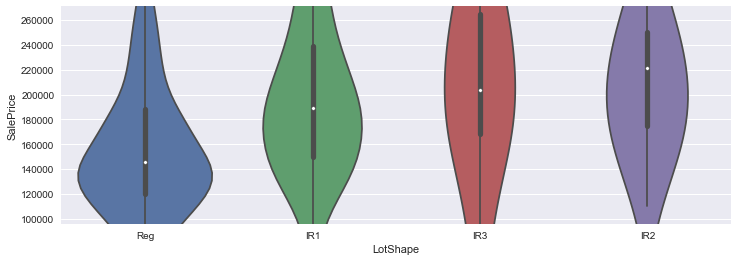

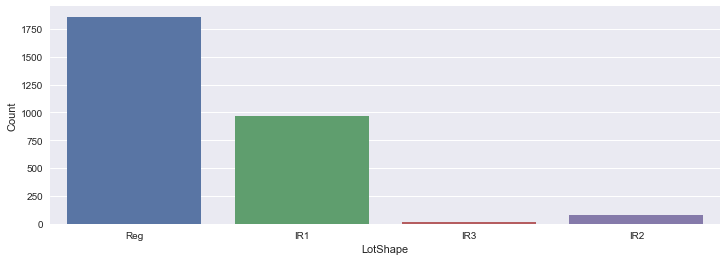

0  missing entries


In [181]:
data_profile(df, 'LotShape')

There's 3 values for irregular lot shape. Let's turn it into a binary variable. Doesn't look like we'll lose a whole lot of information and it makes it easier to train.

#### LandContour

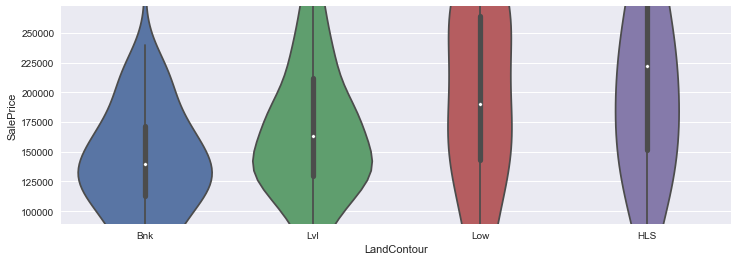

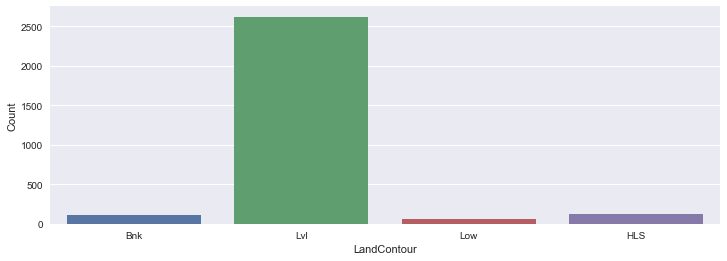

0  missing entries


In [182]:
data_profile(df, 'LandContour')

"Lvl" occurs very often, the other ones do not. Will try to combine Bnk and Lvl and one-hot encode this manually.

#### LotConfig

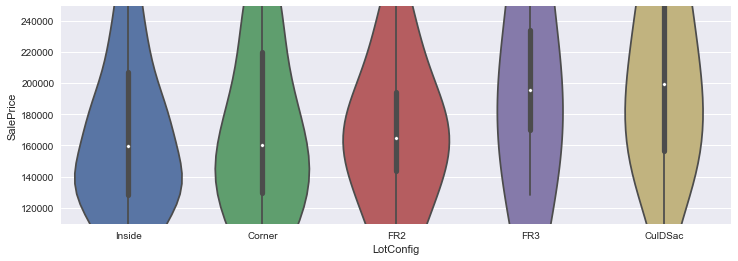

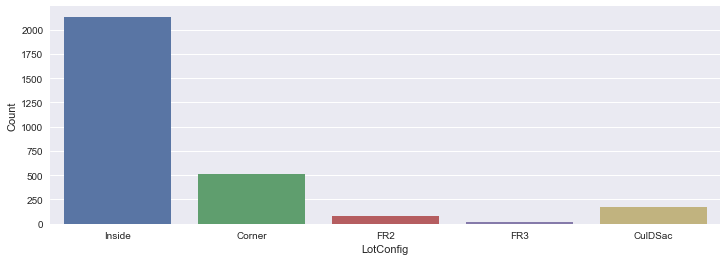

0  missing entries


In [183]:
data_profile(df, 'LotConfig')

Combine FR3 + CuldSac. And Inside + Corner.

### LandSlope

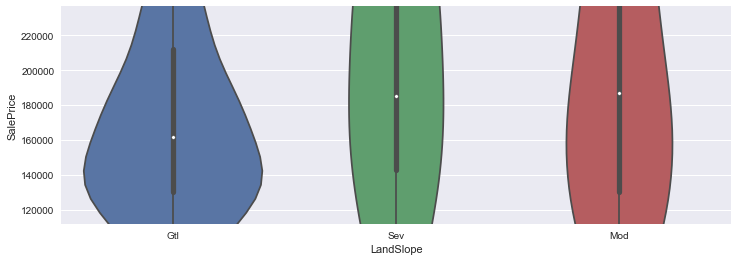

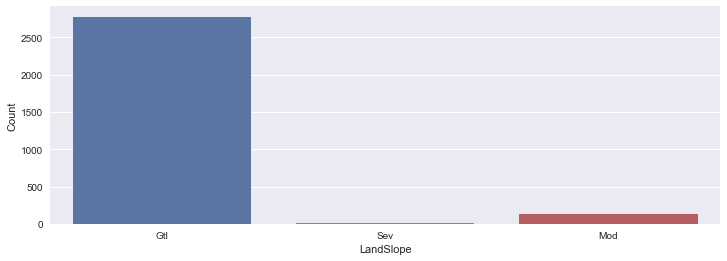

0  missing entries


In [184]:
data_profile(df, 'LandSlope')

Will make a binary value with Gtl or not Gtl.

### Neighbourhood

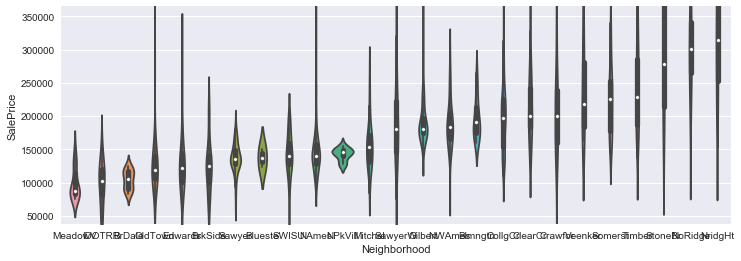

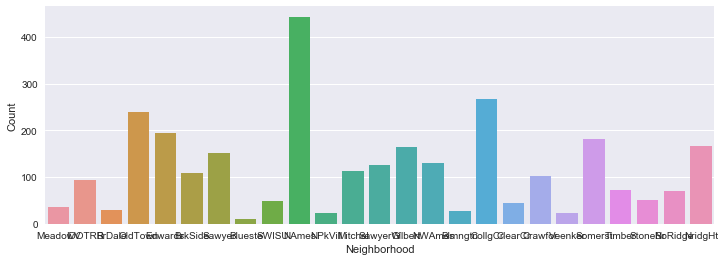

0  missing entries


In [185]:
data_profile(df, 'Neighborhood')

Ok, this looks like a very strong relationship. I can simply one-hot encode all of them.
Or, I could try to make the modelling a little easier by grouping these into cheap, regular and expensive neighbourhoods. Will give that a shot. The cutoffs I'm choosing are a bit arbitrary, I'm looking for big jumps in the graph for the median sale price (the white circle). Will validate if this works with CV.

In [186]:
nb_sp = df.groupby('Neighborhood')[['SalePrice']].median()
nb_sp[nb_sp['SalePrice'] > 200000]

SalePrice
Neighborhood           
ClearCr        200250.0
Crawfor        200624.0
NoRidge        301500.0
NridgHt        315000.0
Somerst        225500.0
StoneBr        278000.0
Timber         228475.0
Veenker        218000.0

Cheap neighbourhoors:

In [187]:
nb_sp[nb_sp['SalePrice'] < 160000].index.get_level_values(0).values

array(['Blueste', 'BrDale', 'BrkSide', 'Edwards', 'IDOTRR', 'MeadowV',
       'Mitchel', 'NAmes', 'NPkVill', 'OldTown', 'SWISU', 'Sawyer'], dtype=object)

Expensive neighbourhoods:

In [188]:
nb_sp[nb_sp['SalePrice'] > 200000].index.get_level_values(0).values

array(['ClearCr', 'Crawfor', 'NoRidge', 'NridgHt', 'Somerst', 'StoneBr',
       'Timber', 'Veenker'], dtype=object)

### YearRemodelAdd,  YearBuilt, YrSold, MoSold

- YearRemodAdd: Remodel date (same as construction date if no remodeling or additions). According to description. But we've already seen a strange peak at 1950.

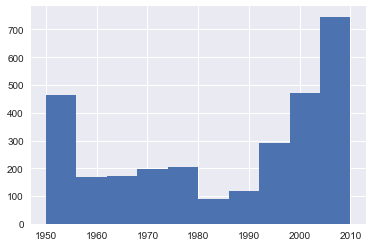

In [189]:
df['YearRemodAdd'].hist()

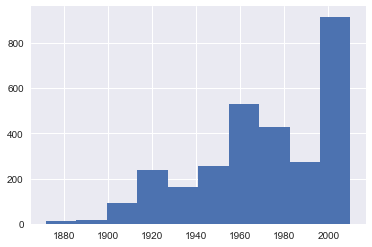

In [190]:
df['YearBuilt'].hist()

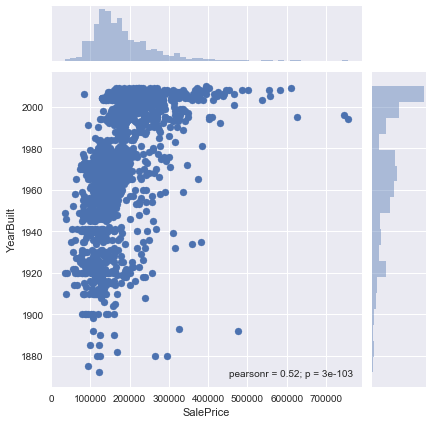

In [191]:
sns.jointplot('SalePrice', 'YearBuilt', df)

Let's try to add some features. Above, I noticed that it makes no sense to keep YoSold and MoSold around. But it might be possible to extract some value from them first.

New: 117 | Old: 2802


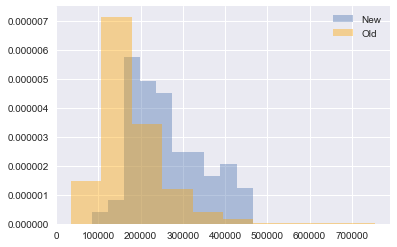

In [192]:
cond = (df['YearBuilt'] == df['YrSold']) | \
       (df['YearBuilt']-1 == df['YrSold'])
hist_compare(cond, "New","Old", df)

Ok, new houses seem more expensive. Will add 'isNew' feature.

NotRemodeledAfterConstruction: 1899 | RemodeledAfterConstruction: 1020


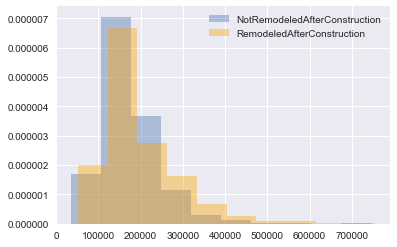

In [193]:
cond = (df['YearBuilt'] == df['YearRemodAdd']) | \
       ((df['YearRemodAdd'] == 1950) & (df['YearBuilt'] != 1950))
hist_compare(cond, 
             "NotRemodeledAfterConstruction",
             "RemodeledAfterConstruction", df)

Not very discriminative. Let's try something else.

RemodeledInYearOfSaleOrLater: 241 | NotRemodeledAfterConstruction: 2678


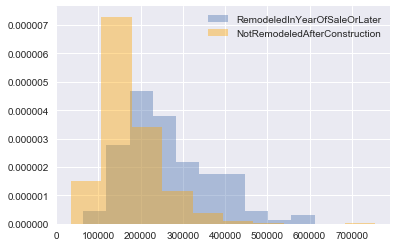

In [194]:
hist_compare((df['YearRemodAdd'] >= df['YrSold']), 
             "RemodeledInYearOfSaleOrLater", 
             "NotRemodeledAfterConstruction",
             df)

Ok, good! Adding this.

In [195]:
df[[COL_Y, 'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold']].corr()

SalePrice  YearBuilt  YearRemodAdd    YrSold    MoSold
SalePrice      1.000000   0.522897      0.507101 -0.028923  0.046432
YearBuilt      0.522897   1.000000      0.612235 -0.012344  0.013938
YearRemodAdd   0.507101   0.612235      1.000000  0.033203  0.017693
YrSold        -0.028923  -0.012344      0.033203  1.000000 -0.153895
MoSold         0.046432   0.013938      0.017693 -0.153895  1.000000

Even though the distributions for YearBuilt and YearRemodAdd look very much non-normal, it's still worthwhile to keep them. Might want to look into bining them into decades and one-hot-encoding that later. But I will fix the 1950 issue.


In [196]:
df['YearRemodAdd'].min()

1950

In [197]:
len(df.loc[(df['YearRemodAdd'] == 1950) & (df['YearBuilt'] == 1950), :])

22

In [198]:
len(df.loc[(df['YearRemodAdd'] == 1950) & (df['YearBuilt'] > 1950), :])

0

In [199]:
len(df.loc[(df['YearRemodAdd'] == 1950) & (df['YearBuilt'] < 1950), :])

339

It could be that all these houses were infact remodeled in 1950, but it looks too fishy to me...

YrSold and MoSold will be dropped. Can take a quick look at MoSold, just in case:

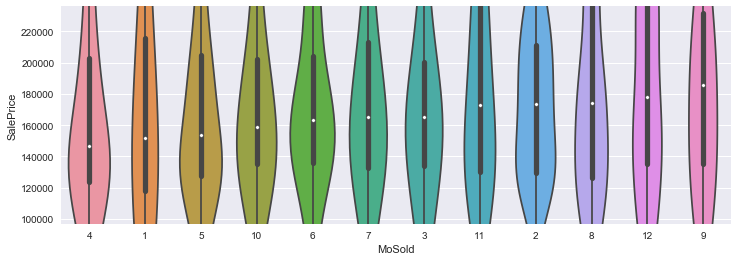

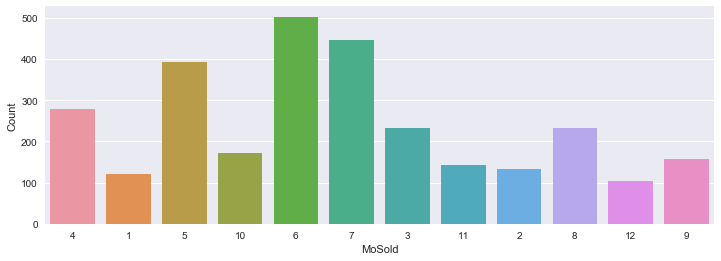

0  missing entries


In [200]:
data_profile(df, 'MoSold', dtype='cat')

What's up with this?
Good months: 2, 8, 9, 11 12
Bad months: 1, 4, 5, 10

I could maybe try one-hot-encoding this so that each month can be used individually but it doesn't really make sense to me intuitively. As it is right now, as an ordinal column, it's just noise. Definitively dropping it.

### Roof

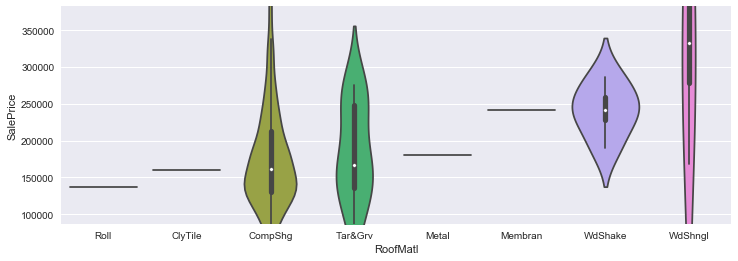

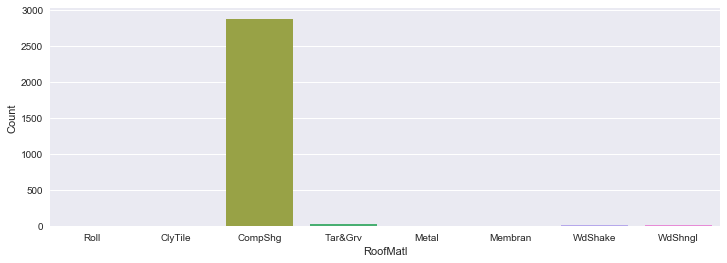

0  missing entries


In [201]:
data_profile(df, 'RoofMatl')

I can't see this adding much predictive value, only a lot of noise.

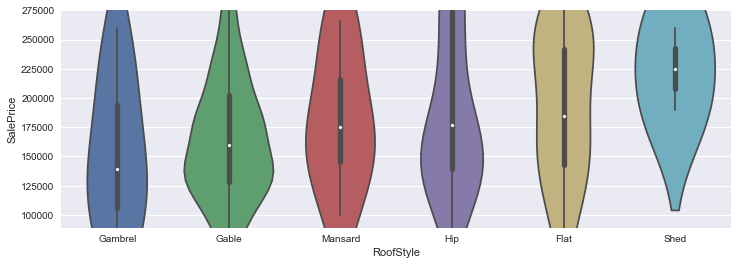

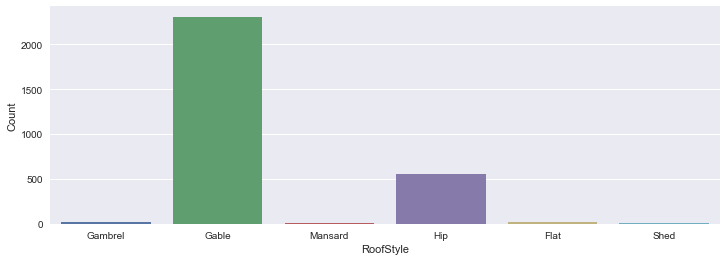

0  missing entries


In [202]:
data_profile(df, 'RoofStyle')

This might help but there's many categories with few values. I'll combine Gambrel and Gable. And Mansard, Hip, Flat, Shed.

### MiscFeature

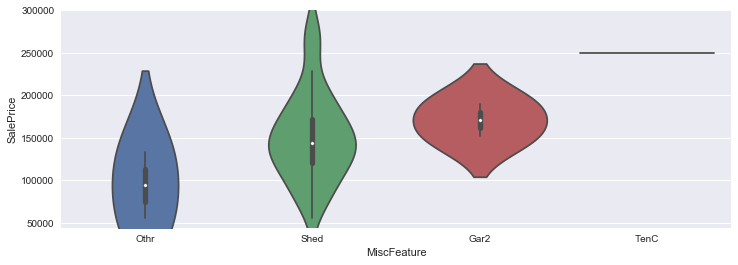

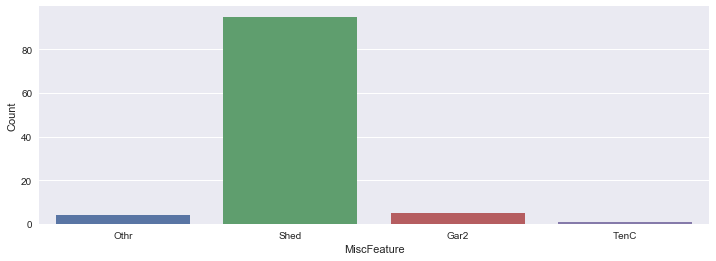

2814  missing entries


In [203]:
data_profile(df, 'MiscFeature')

Ok, only shed has a meaningful amount of values. Gar2 could be used to distinguish expensive houses but I thinking this is already incorporated in the garage size / nr. of vehicles. Let's compare shed v.s. nonshed.

Shed: 95 | No Shed: 2824


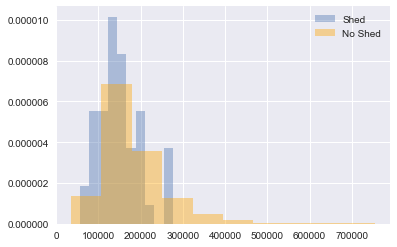

In [204]:
hist_compare(df['MiscFeature'] == 'Shed', 'Shed', 'No Shed', df)

No, too much overlap. Dropping it.

(Note to self: look into consistent binning between the 2 histograms)

### Condition1, condition2

    Artery	Adjacent to arterial street
    Feedr	Adjacent to feeder street	
    Norm	Normal	
    RRNn	Within 200' of North-South Railroad
    RRAn	Adjacent to North-South Railroad
    PosN	Near positive off-site feature--park, greenbelt, etc.
    PosA	Adjacent to postive off-site feature
    RRNe	Within 200' of East-West Railroad
    RRAe	Adjacent to East-West Railroad
    
Ok, there's 2 columns that have the same entries. These should definitely be combined when one-hot-encoding. Makes no sense to have a separate Condition1_Feedr and a separate Condition2_Feedr. But let's focus on Condition1 for the analysis because it contains more values that aren't "Normal".

In [205]:
df['Condition1'].value_counts()

Norm      2511
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64

In [206]:
df['Condition2'].value_counts()

Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

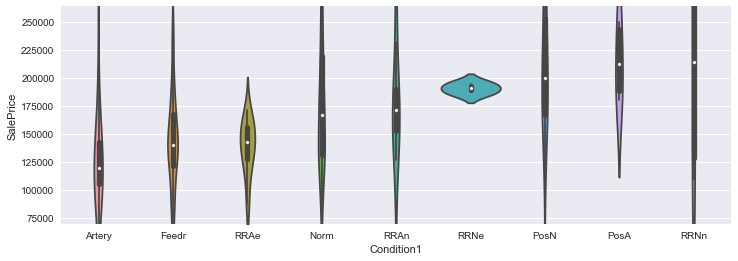

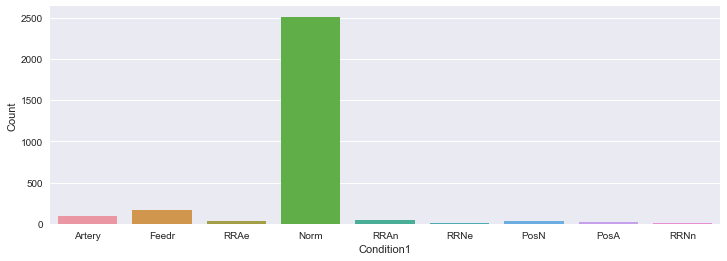

0  missing entries


In [207]:
data_profile(df, 'Condition1')

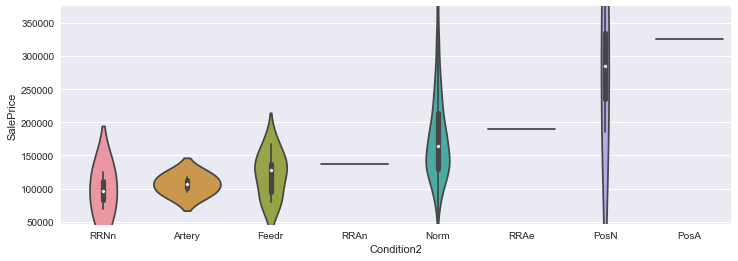

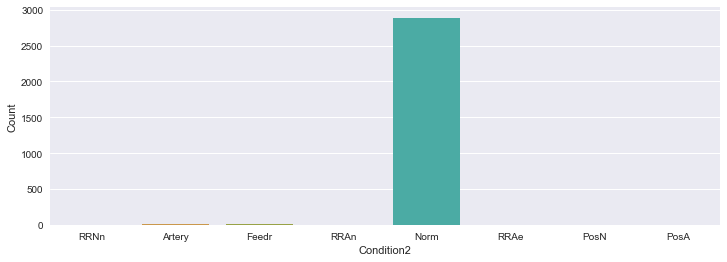

0  missing entries


In [208]:
data_profile(df, 'Condition2')

Notice how RRNn is on the right side for Condition1 and left for Condition2?

Ok, I'm willing to accept that being close to an Artery of Feedr results in a low price. Will one hot encode these manually and drop the others. The difference between artery and feedr is big enough to warrant their own variables.

## Exterior1st, Exterior2nd
Same story as for Condition.

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

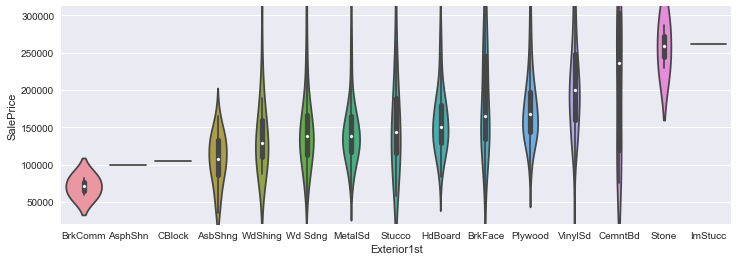

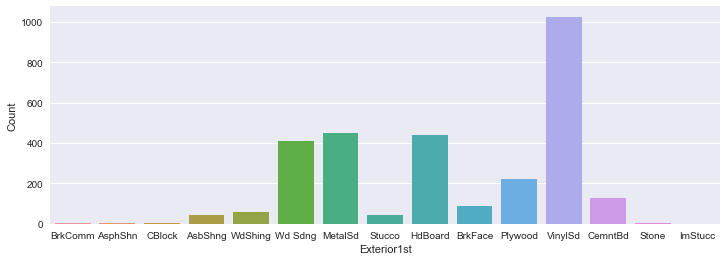

1  missing entries


In [209]:
data_profile(df, 'Exterior1st')

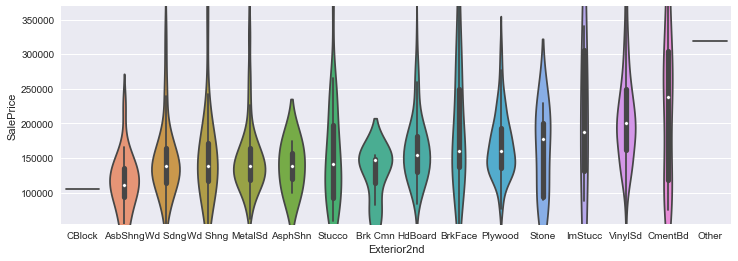

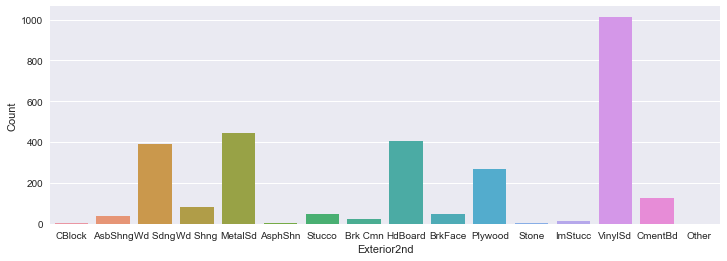

1  missing entries


In [210]:
data_profile(df, 'Exterior2nd')

I'm only keeping the materials with a sizeable amount of examples:

Cheap materials
- AsbShng
- WdShing
- Wd Sdng
- MetalSd

Medium materials:
- Stucco
- HdBoard
- BrkFace
- Plywood

Expensive materials:
- VinylSd
- CemntBd
- CmentBd (looks like they made a typo!)
- ImStucc

Will hot encode these as three variables.

### SaleCondition, SaleType, HouseStyle, MasVnrType, Electrical, BldgType, Foundation, Heating

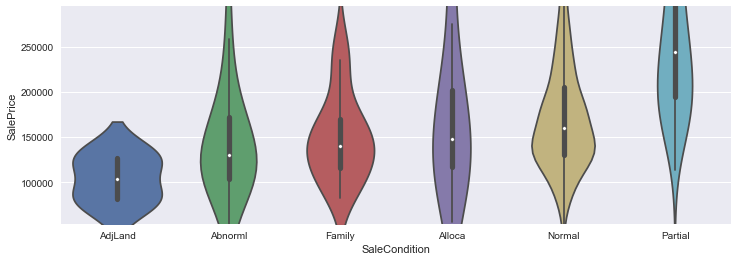

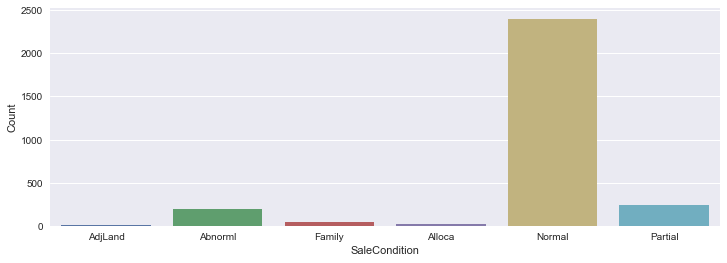

0  missing entries


In [211]:
data_profile(df, 'SaleCondition')

There's a lot in Normal and not a whole lot in the others. Some relation with SalePrice but I'm not really convinced. Will try to drop it.

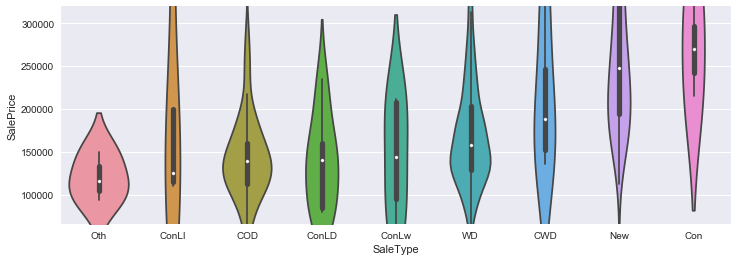

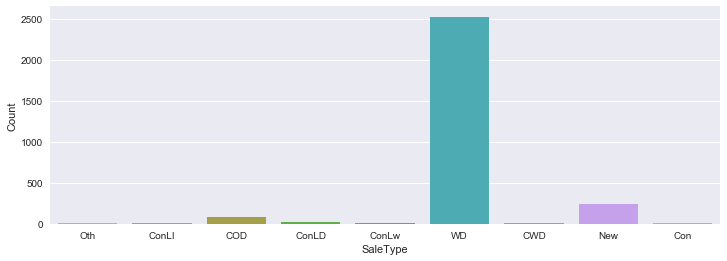

1  missing entries


In [212]:
data_profile(df, 'SaleType')

Same as SaleCondition; dropping it; although WD v.s. New does look kind of interesting.

HouseStyle:

    1Story	One story
    1.5Fin	One and one-half story: 2nd level finished
    1.5Unf	One and one-half story: 2nd level unfinished
    2Story	Two story
    2.5Fin	Two and one-half story: 2nd level finished
    2.5Unf	Two and one-half story: 2nd level unfinished
    SFoyer	Split Foyer
    SLvl	Split Level

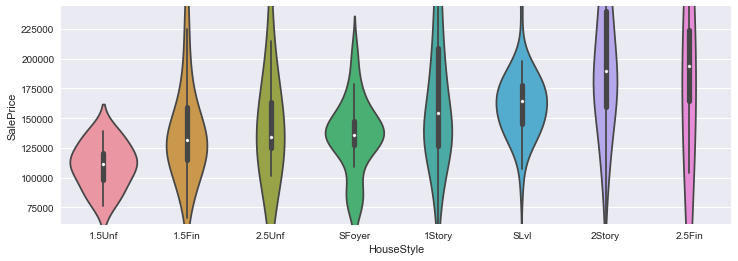

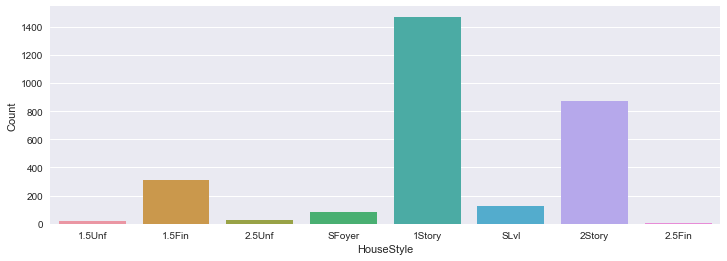

0  missing entries


In [213]:
data_profile(df, 'HouseStyle')

It seems worthwhile to keep this. Will merge 2.5Fin into 2Story and 2.5Unf into 1.5Fin.
We can consider something more elaborate, maybe a flag for "Unfinished 2nd story". Maybe later.

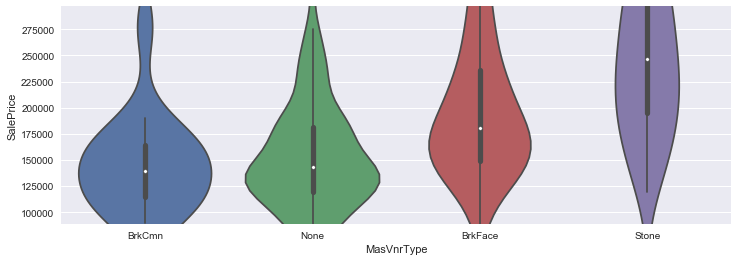

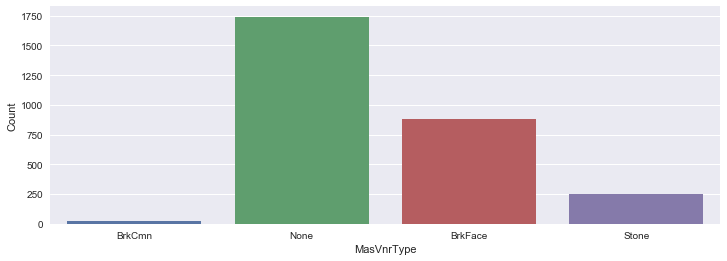

24  missing entries


In [214]:
data_profile(df, 'MasVnrType')

Let's check the missing values.

In [215]:
df[df['MasVnrType'].isnull()][['MasVnrType', 'MasVnrArea']]

MasVnrType  MasVnrArea
Id                         
235         NaN         NaN
530         NaN         NaN
651         NaN         NaN
937         NaN         NaN
974         NaN         NaN
978         NaN         NaN
1244        NaN         NaN
1279        NaN         NaN
1692        NaN         NaN
1707        NaN         NaN
1883        NaN         NaN
1993        NaN         NaN
2005        NaN         NaN
2042        NaN         NaN
2312        NaN         NaN
2326        NaN         NaN
2341        NaN         NaN
2350        NaN         NaN
2369        NaN         NaN
2593        NaN         NaN
2611        NaN       198.0
2658        NaN         NaN
2687        NaN         NaN
2863        NaN         NaN

Only one. We'll leave that MasVnrType to be imputed. The others will be filled "None", 0 respectively.

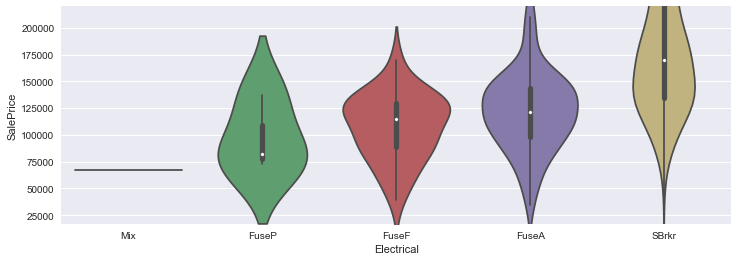

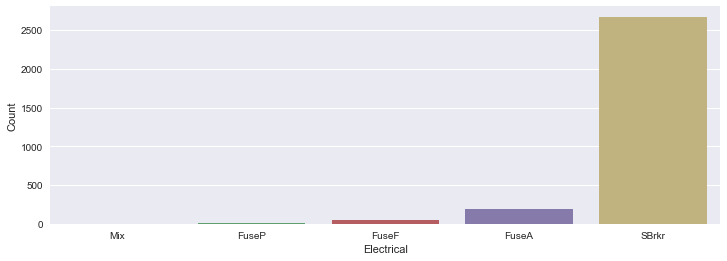

1  missing entries


In [216]:
data_profile(df, 'Electrical')

Very few entries in elements other than SBrkr. Will drop the column.

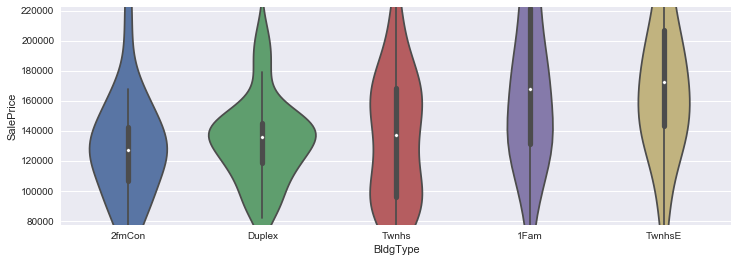

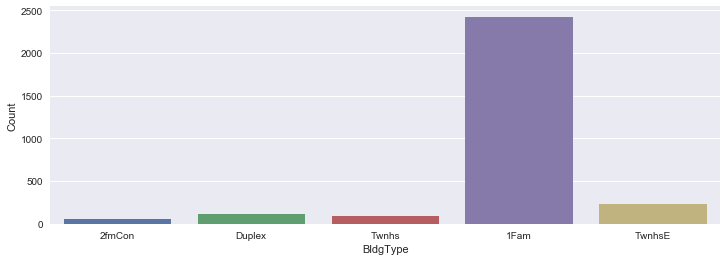

0  missing entries


In [217]:
data_profile(df, 'BldgType')

Keeping this for now.

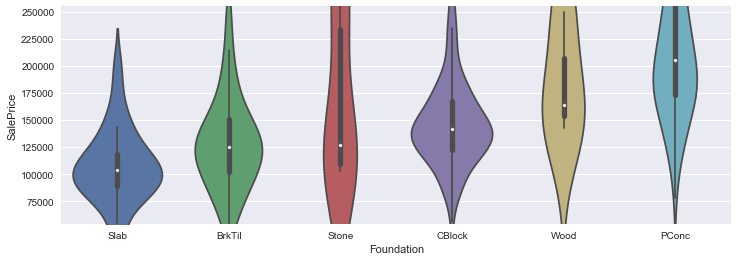

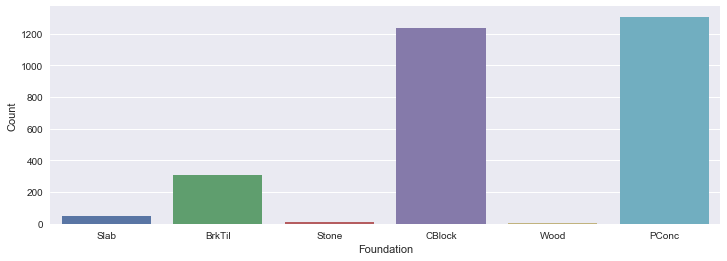

0  missing entries


In [218]:
data_profile(df, 'Foundation')

Having so few values for Stone and Wood might be problematic. I'll try to delete those and impute a value for similar houses. Not exactly true to reality, but makes for an easier to train model.

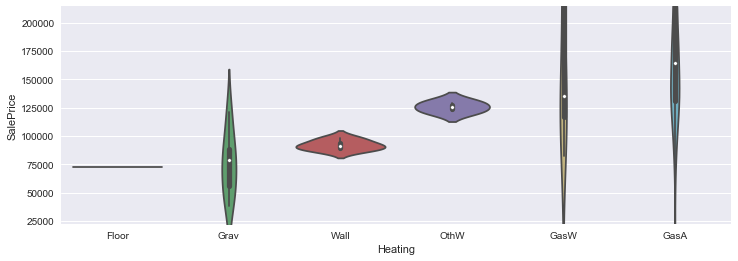

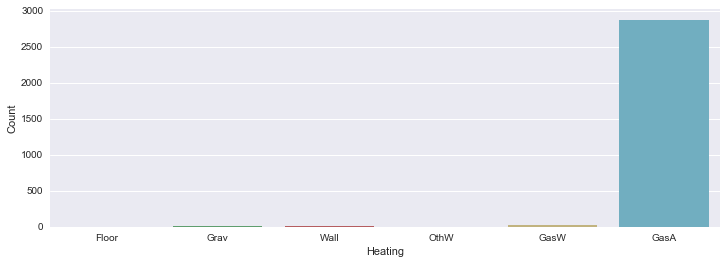

0  missing entries


In [219]:
data_profile(df, 'Heating')

Again, deleting "Floor" and "OthW" to let it get imputed to be one of the remaining categories seems to have improved my CV score a little bit. Deleting it entirely wasn't a good idea, as was a binary encoding using only GasA.

#### Functional

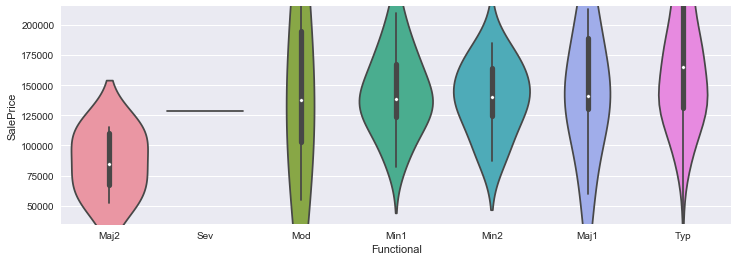

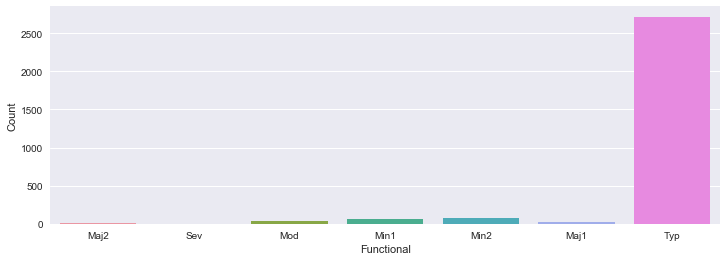

2  missing entries


In [220]:
data_profile(df, 'Functional')

Very few values in anything except Typ. Tried one-hot-encoding for Typ, but that decreased score a little bit. Dropping as well. Unsure what to do with this one.

# Numeric columns

In [221]:
num_cols = [c for c in df.columns if df[c].dtype != 'object' and len(df[c].value_counts()) > 15]
num_cols = np.sort(num_cols)

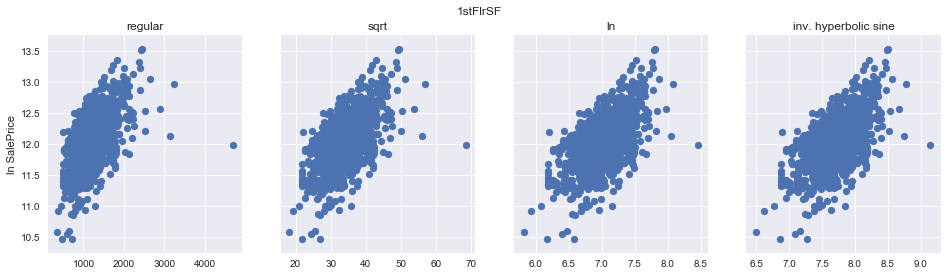

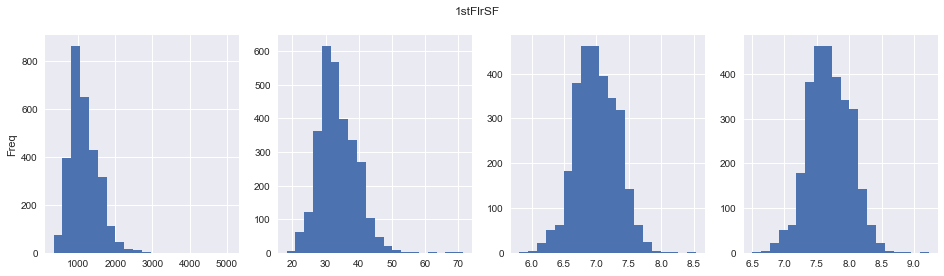

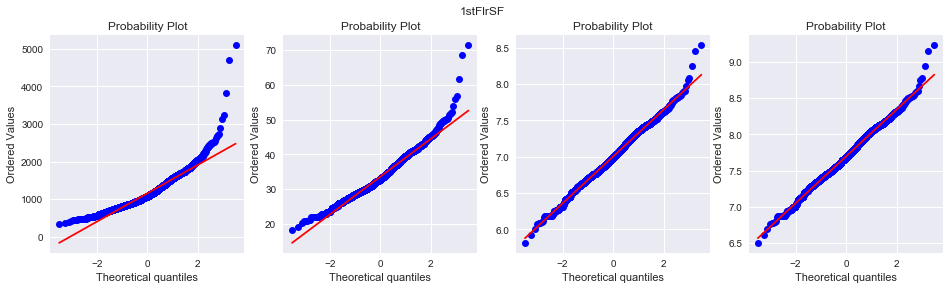

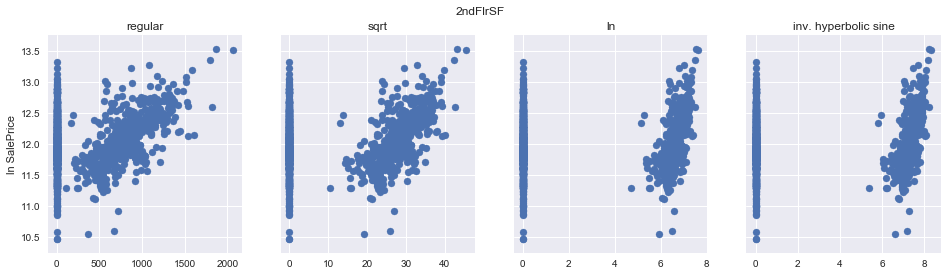

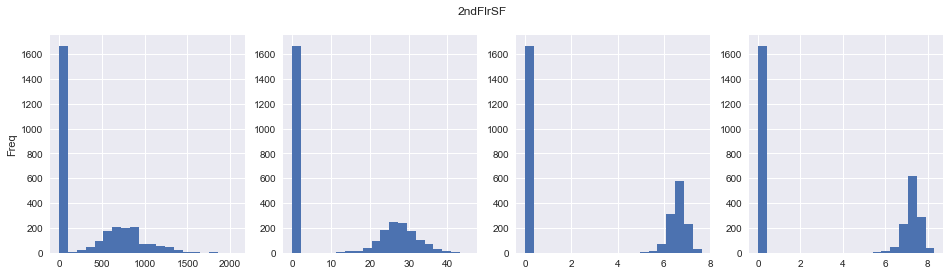

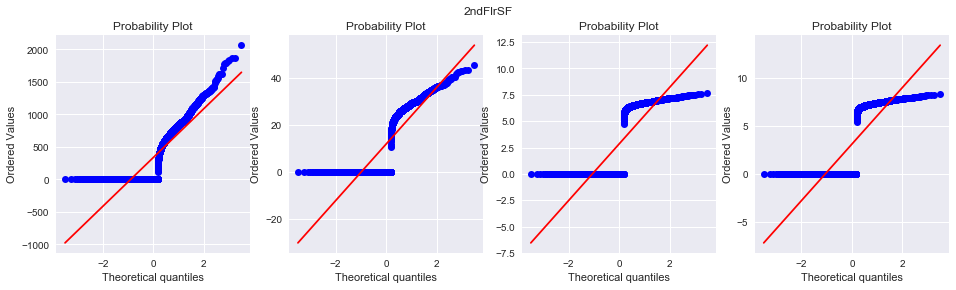

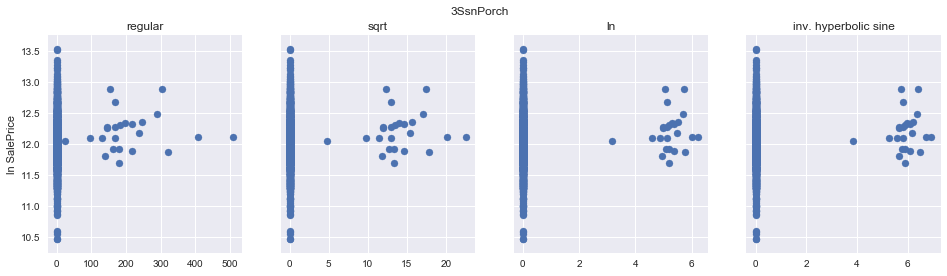

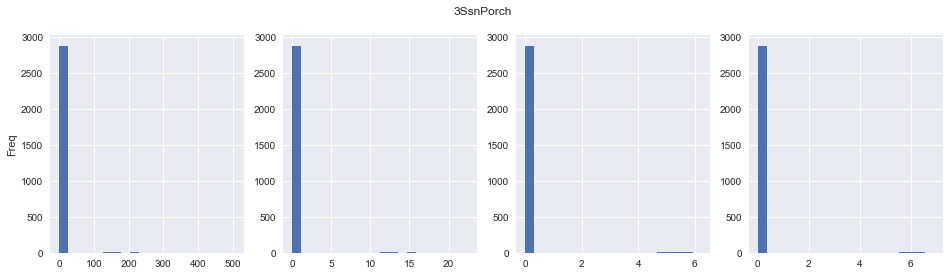

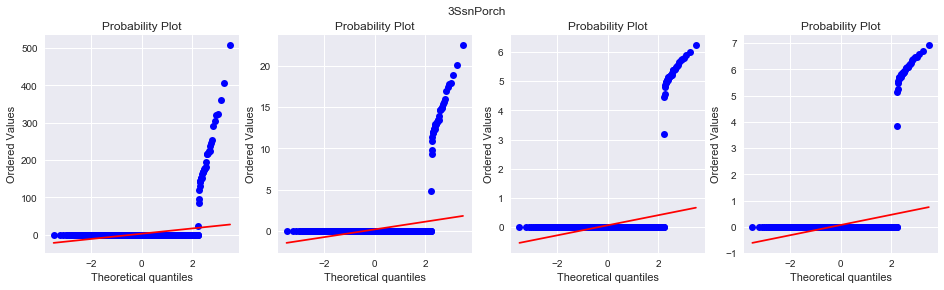

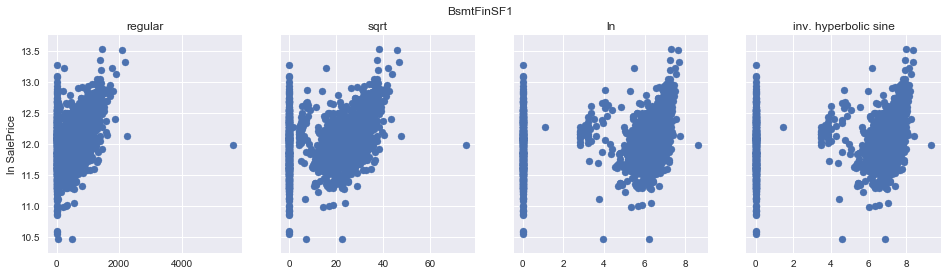

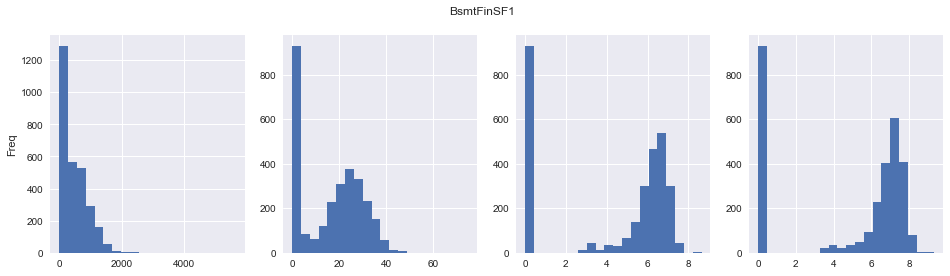

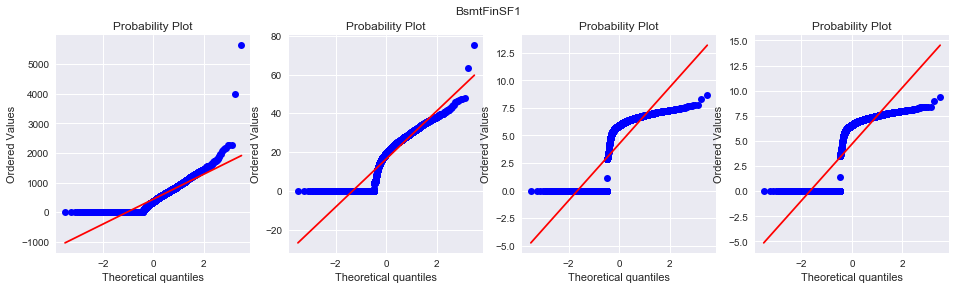

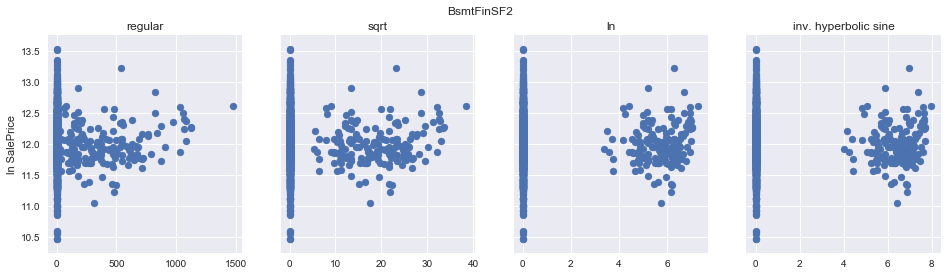

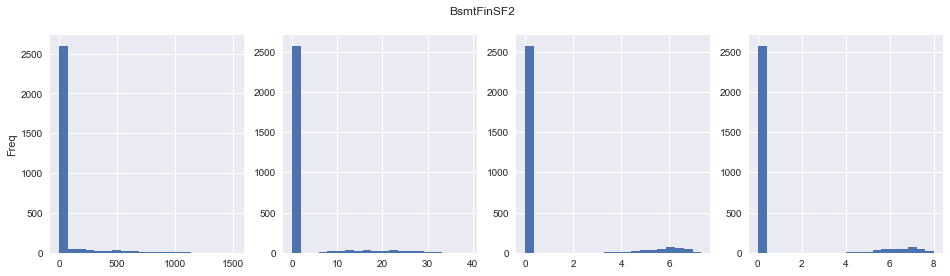

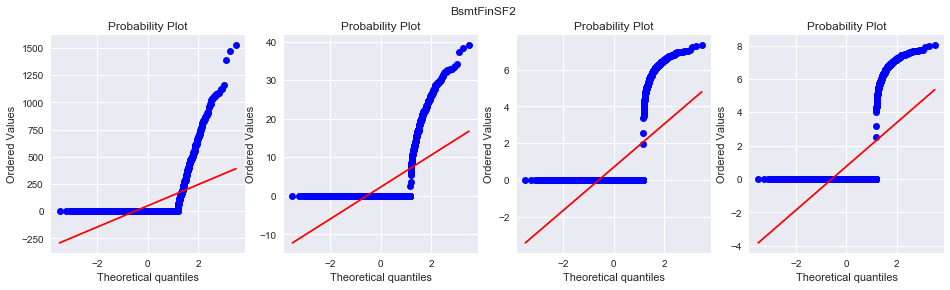

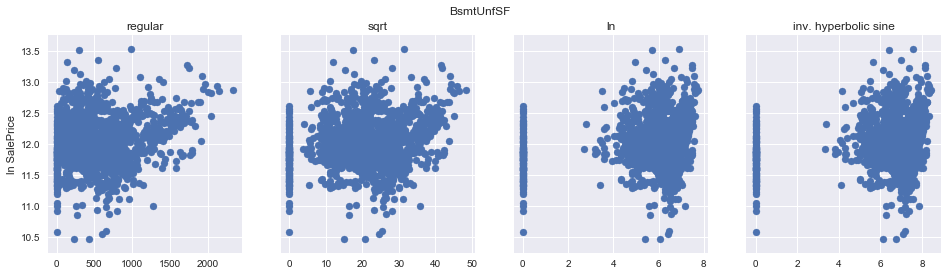

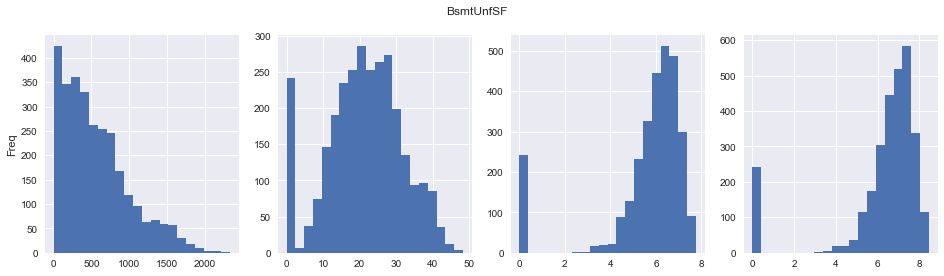

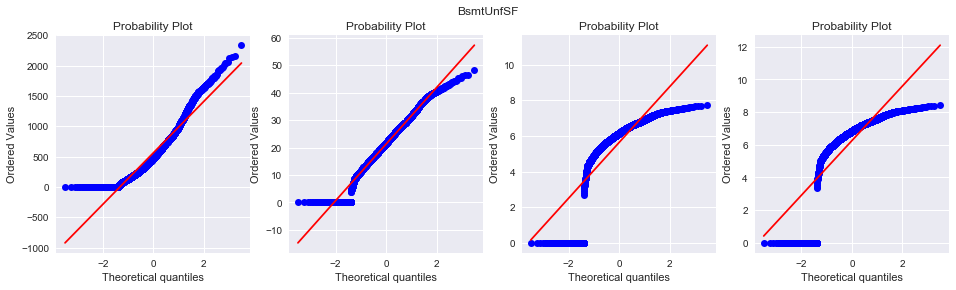

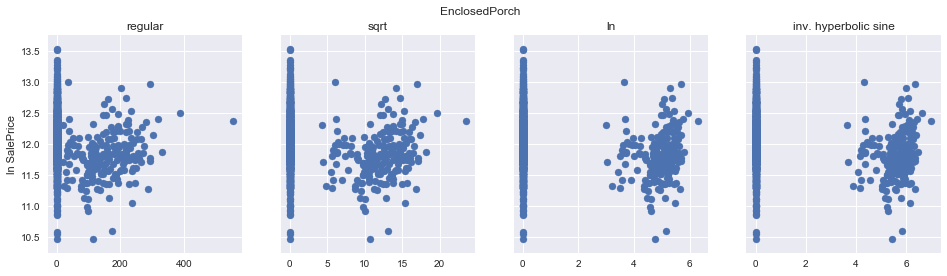

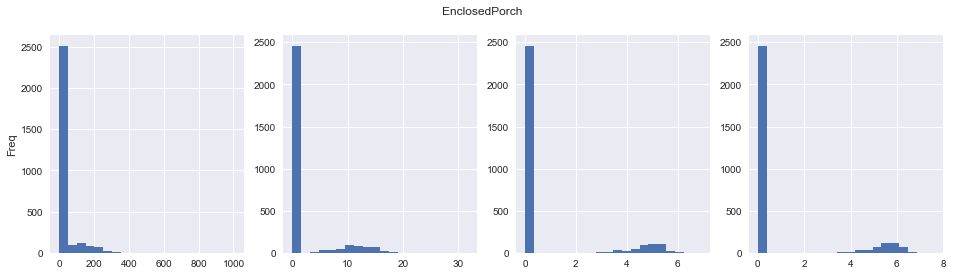

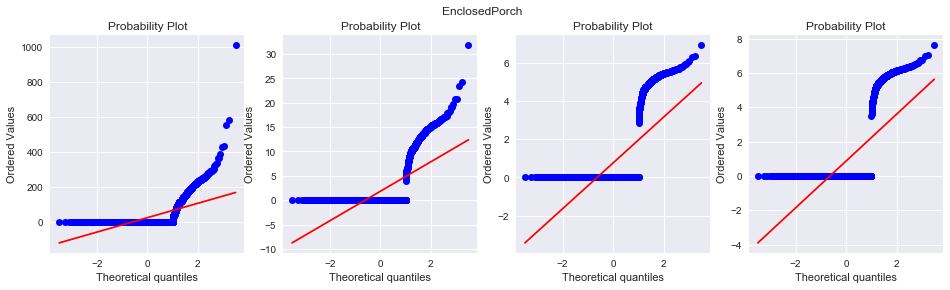

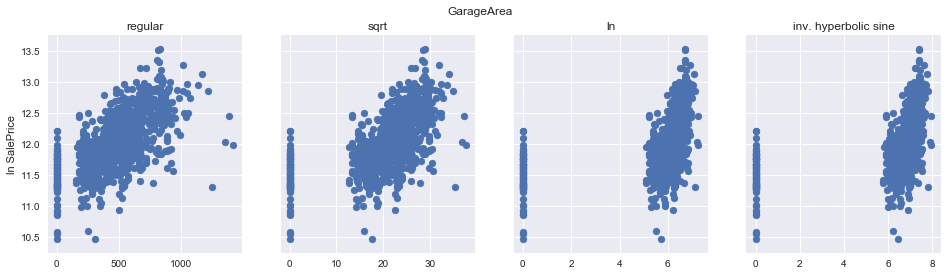

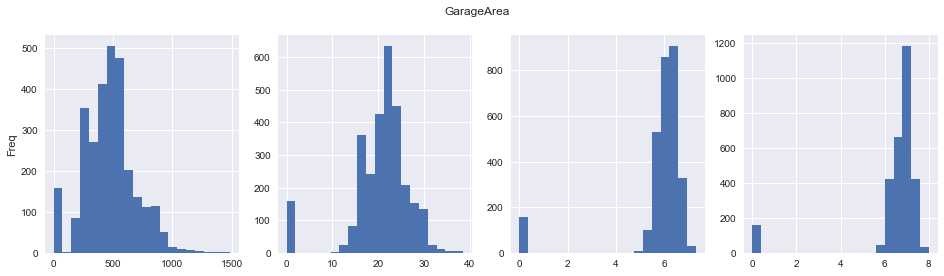

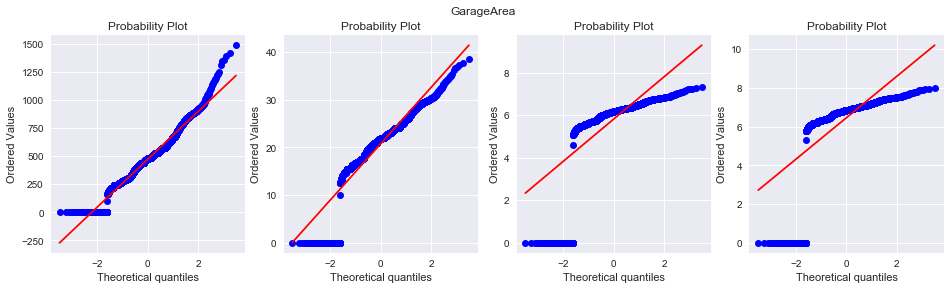

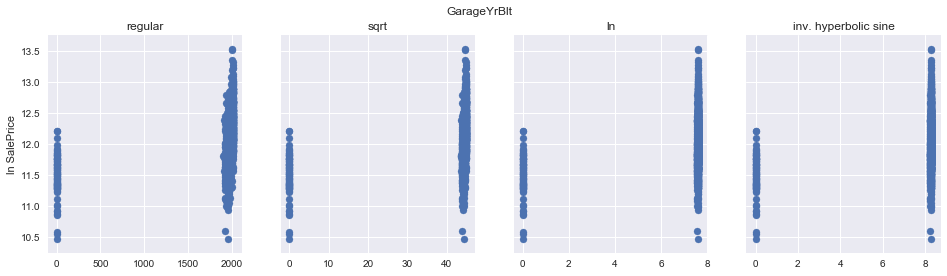

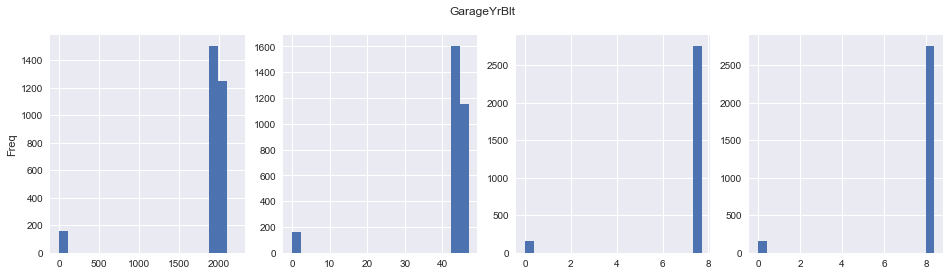

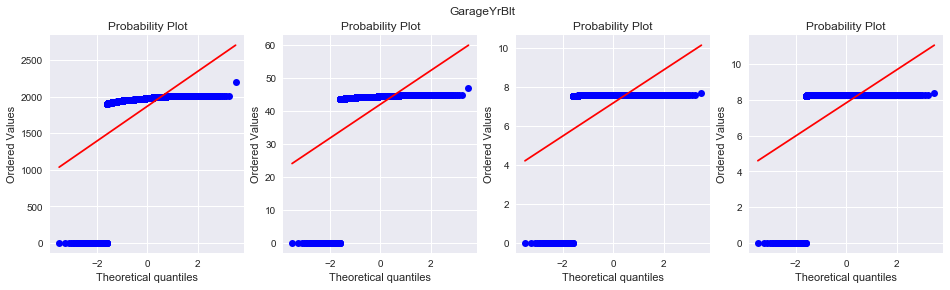

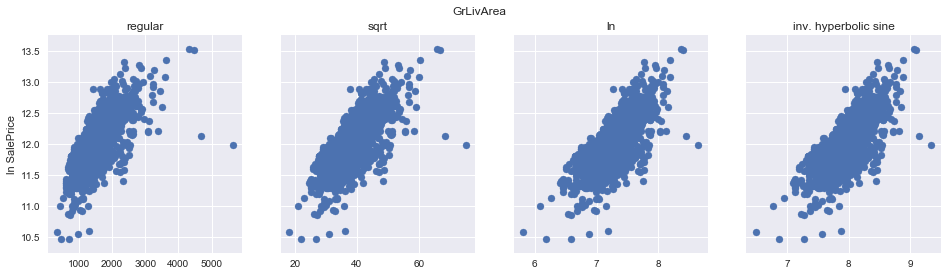

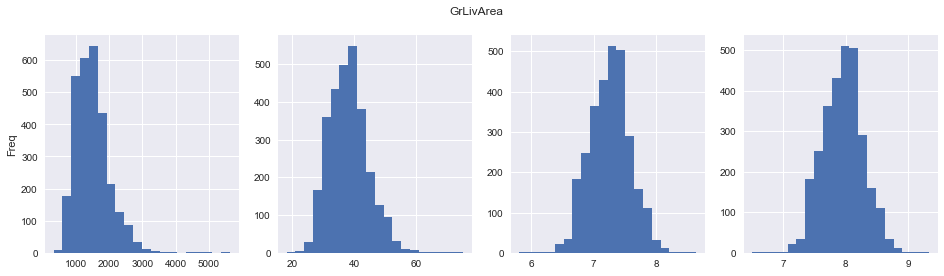

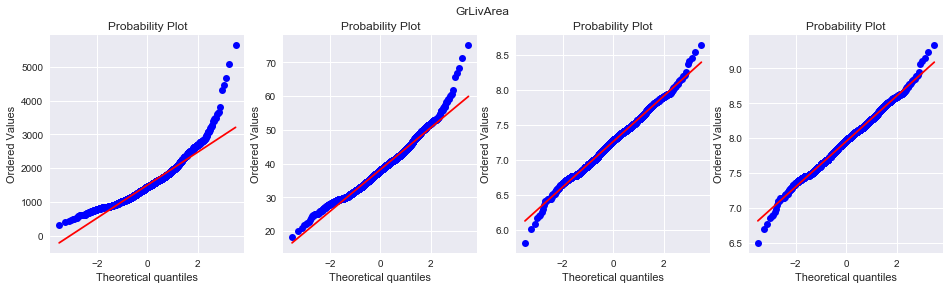

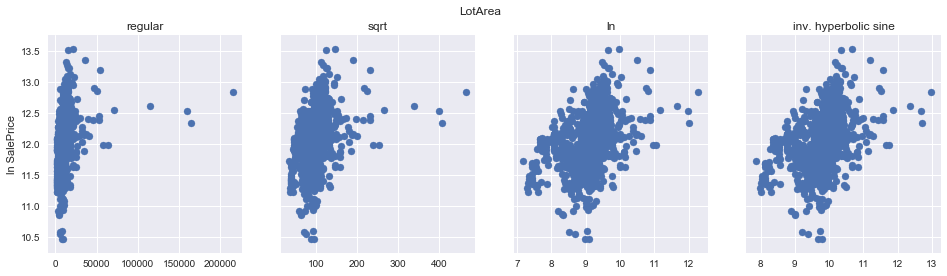

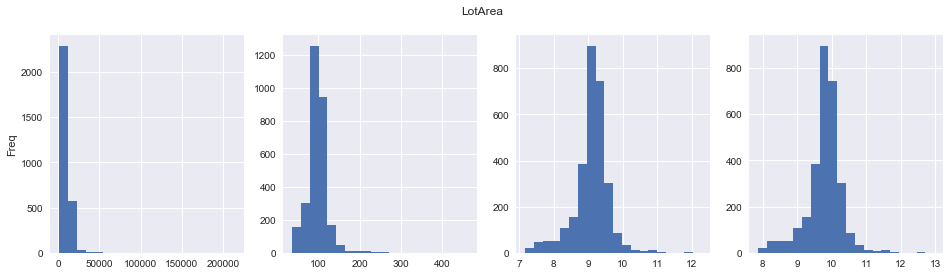

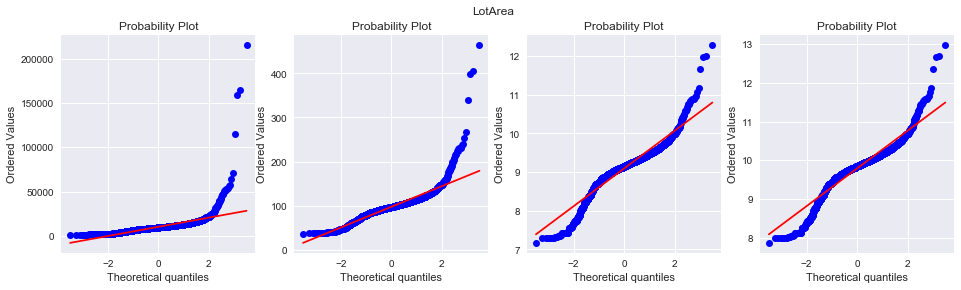

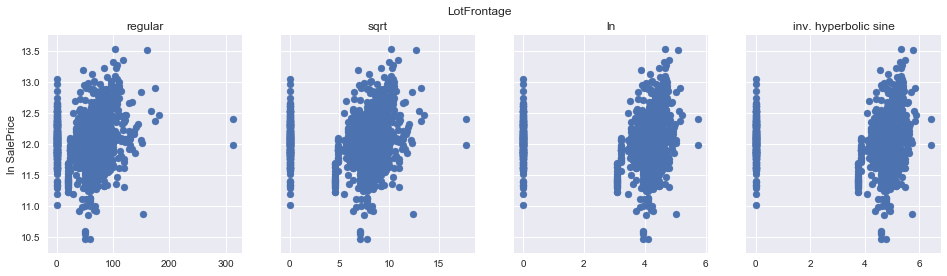

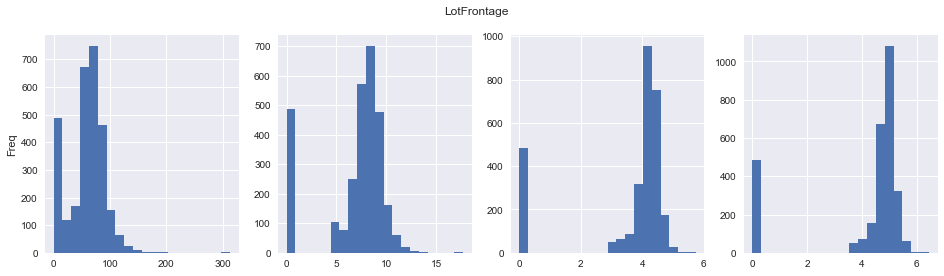

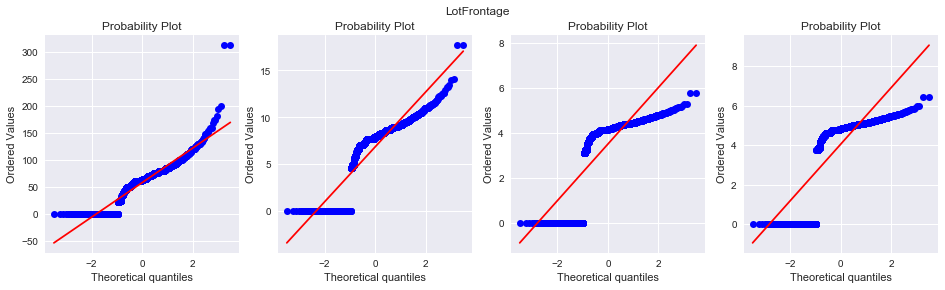

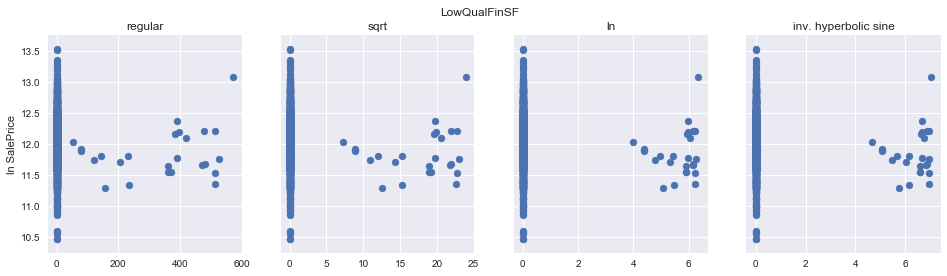

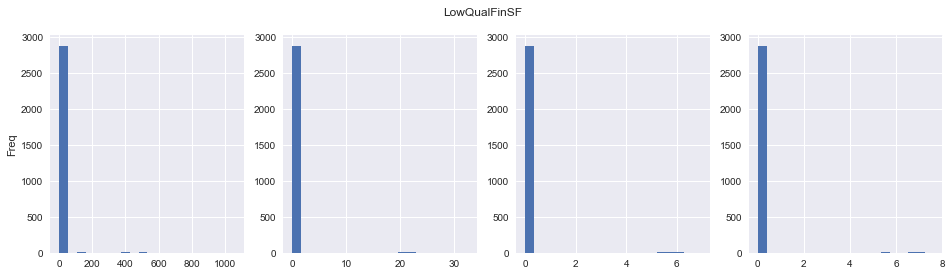

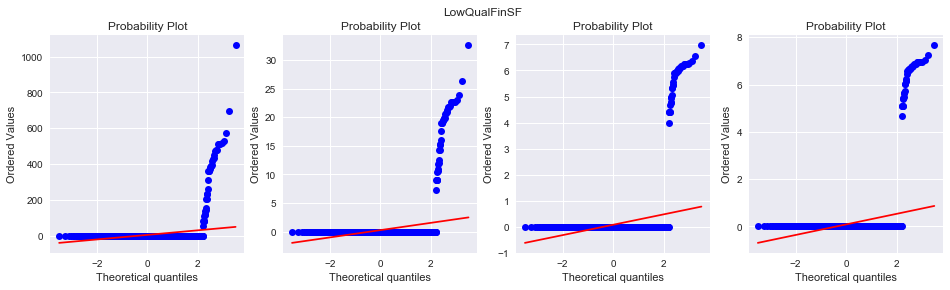

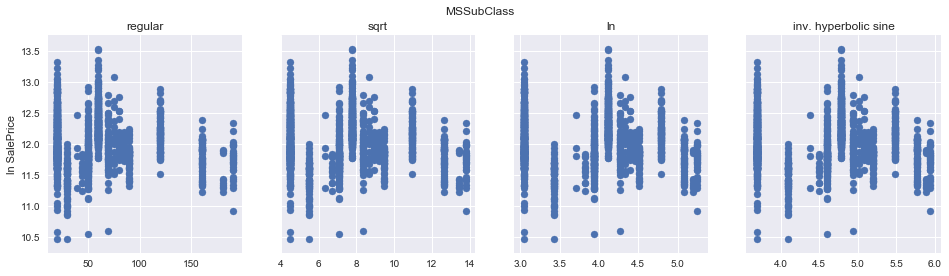

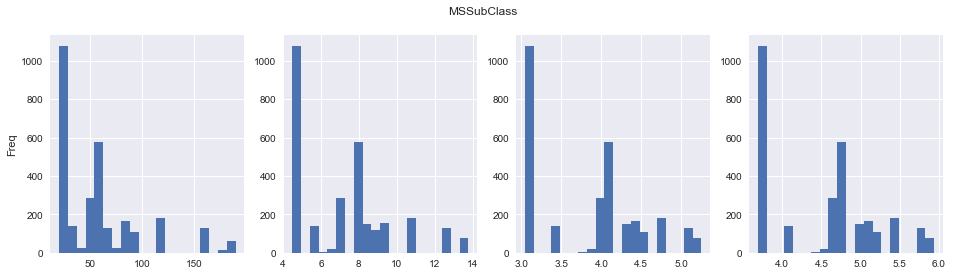

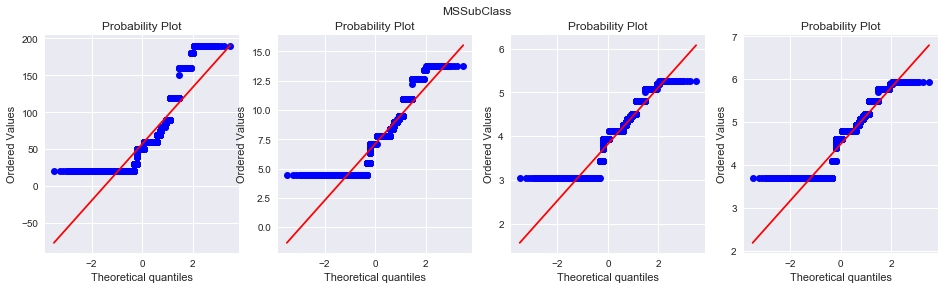

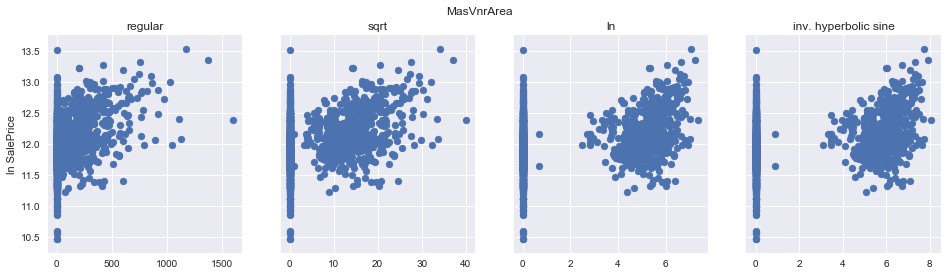

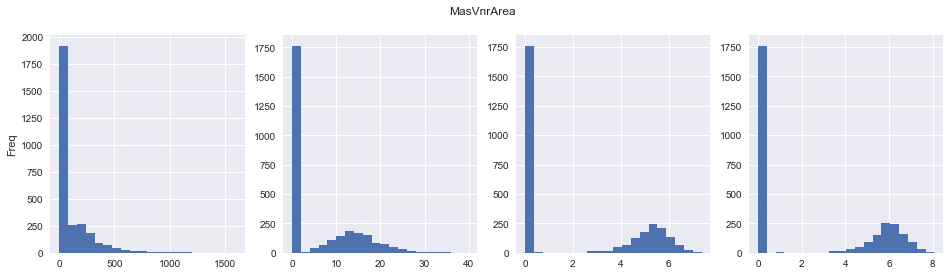

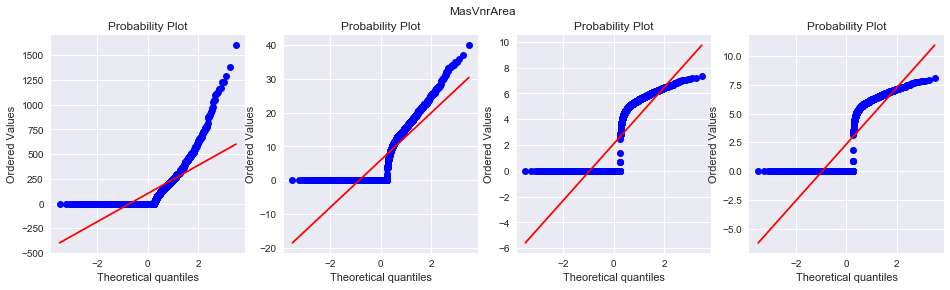

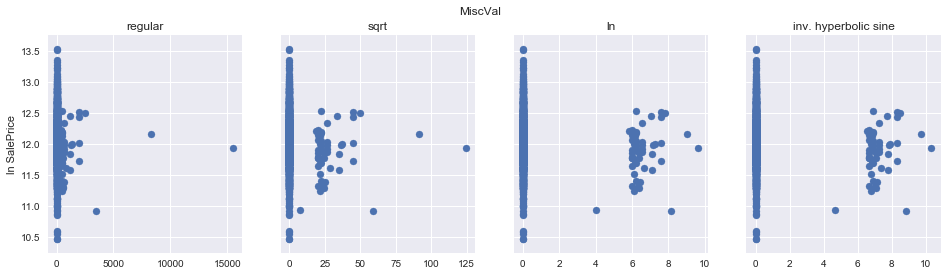

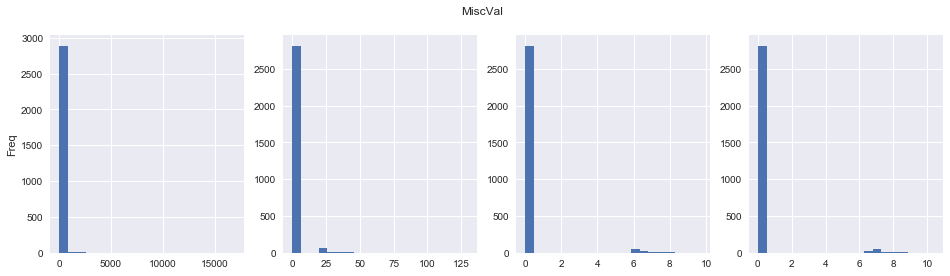

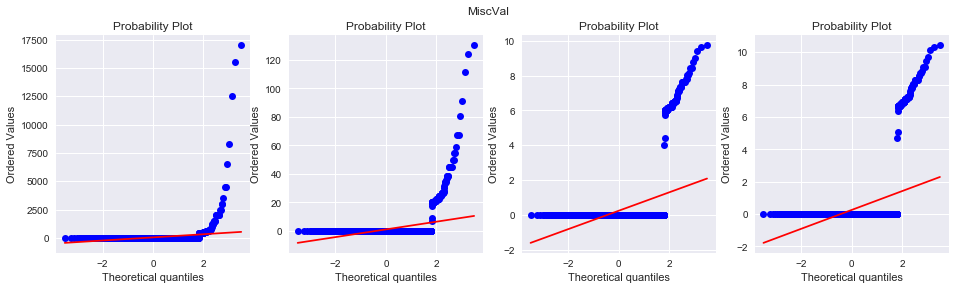

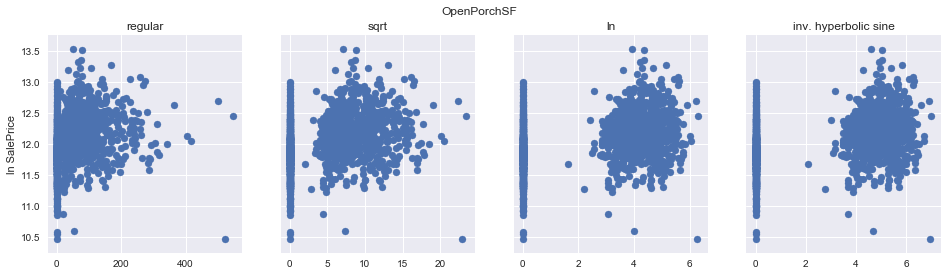

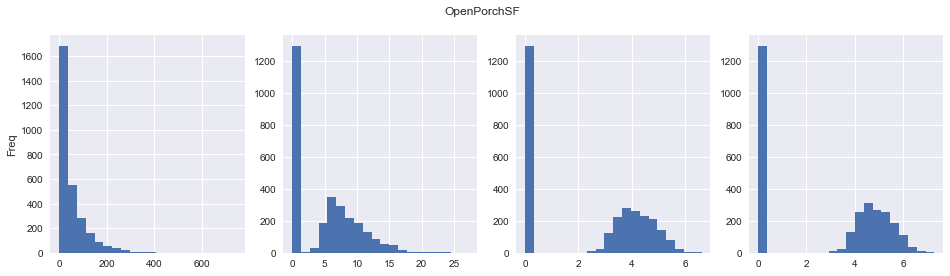

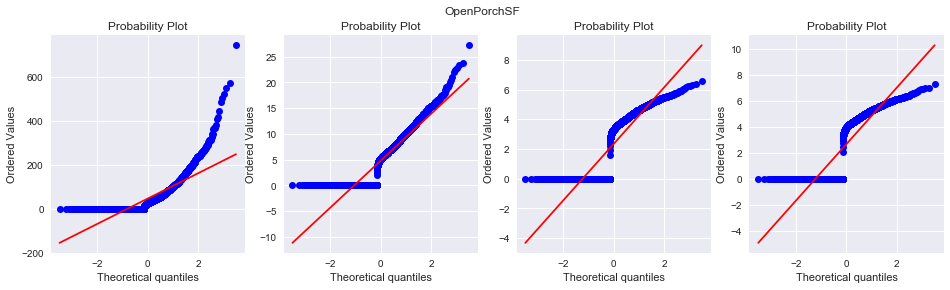

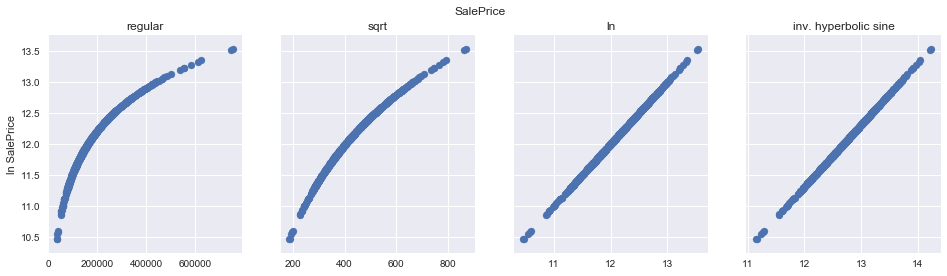

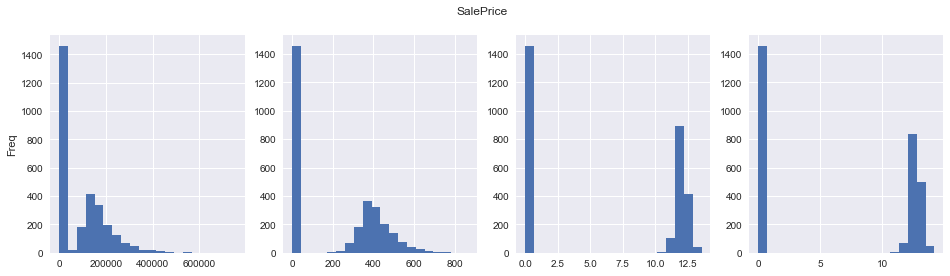

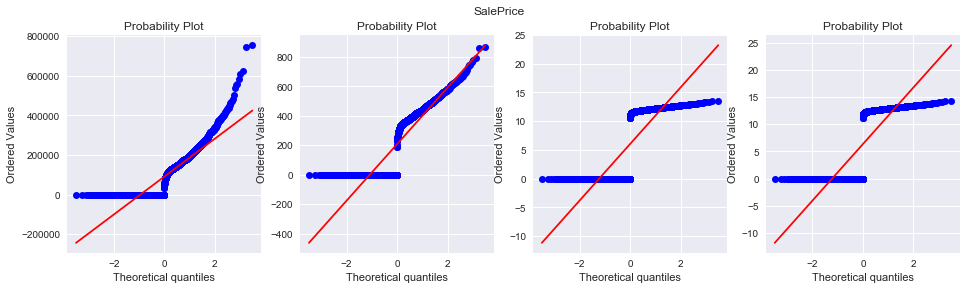

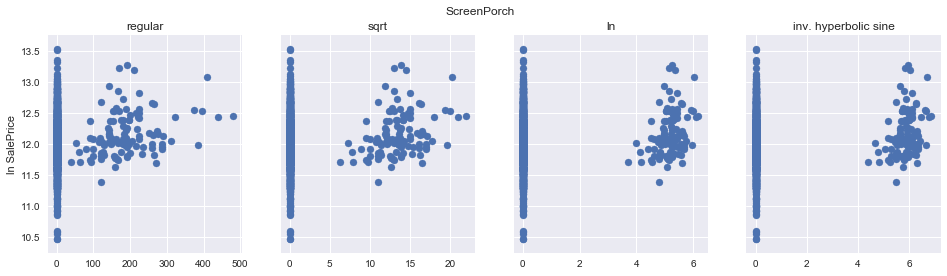

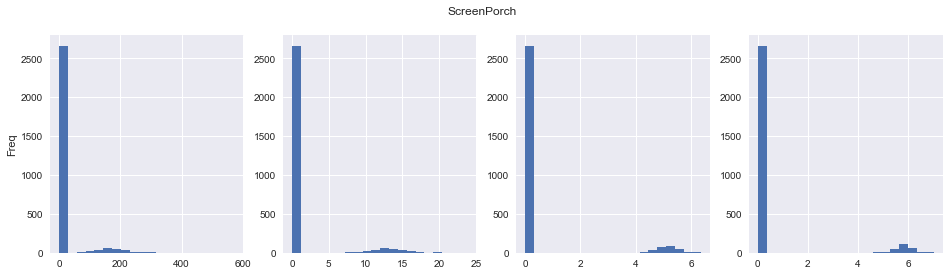

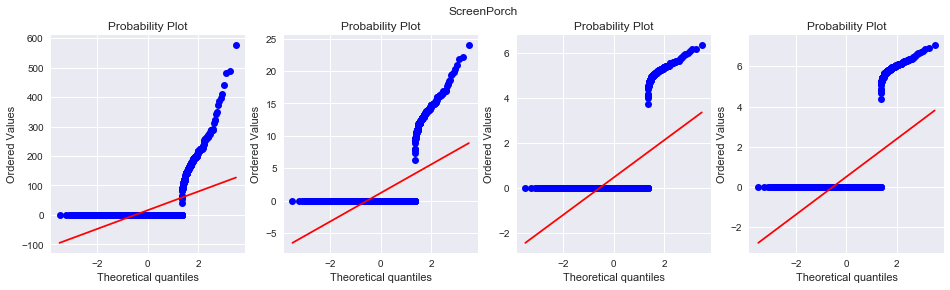

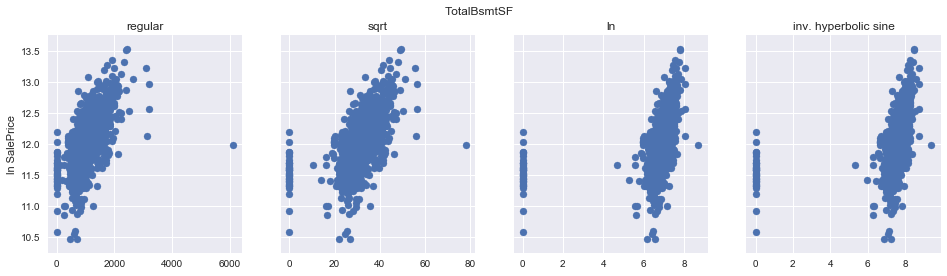

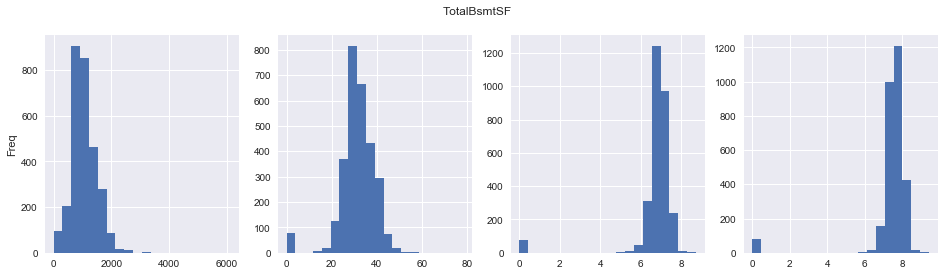

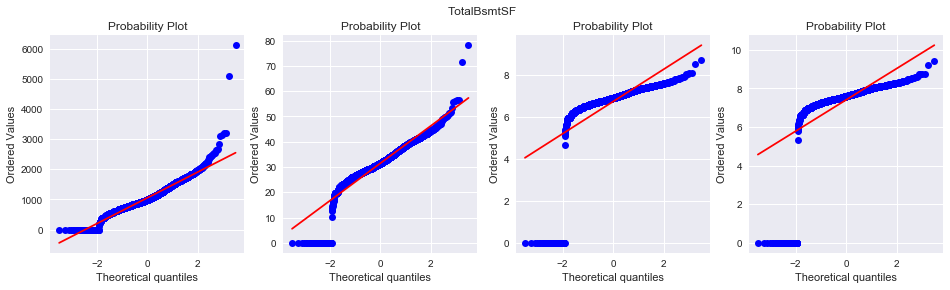

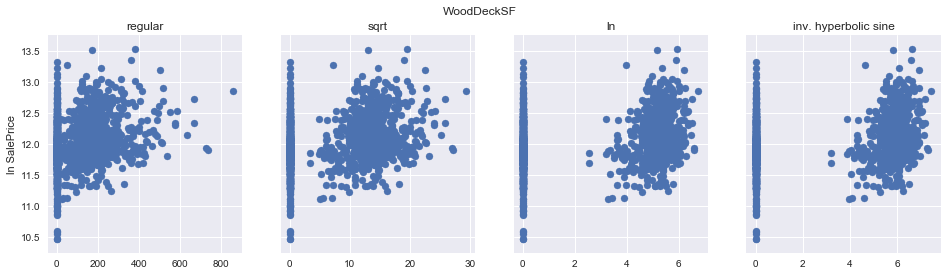

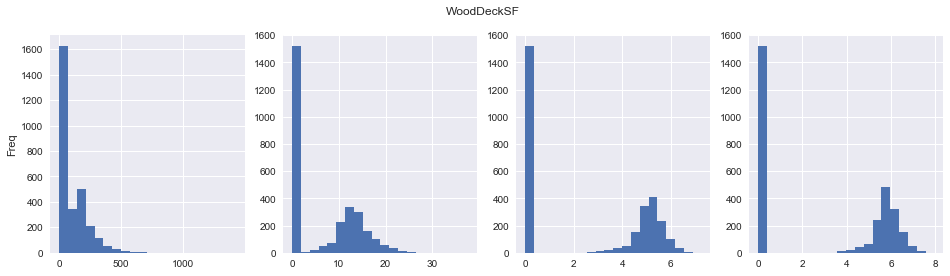

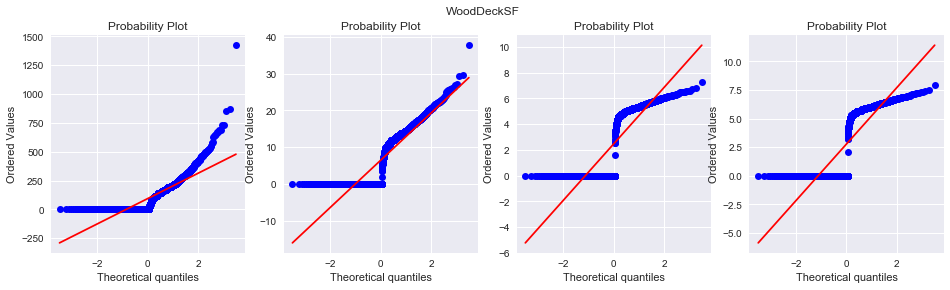

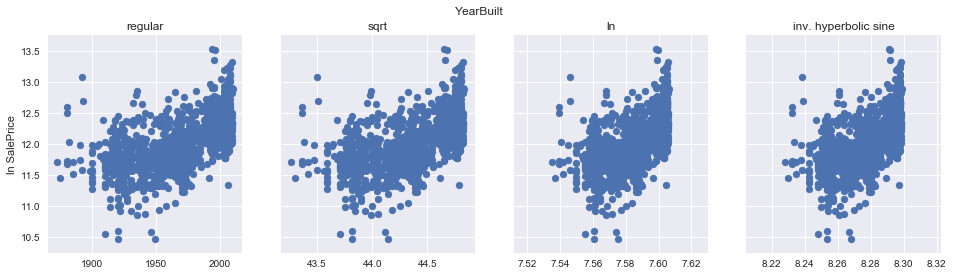

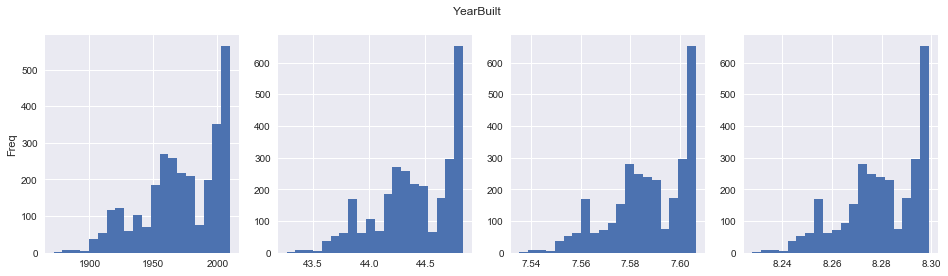

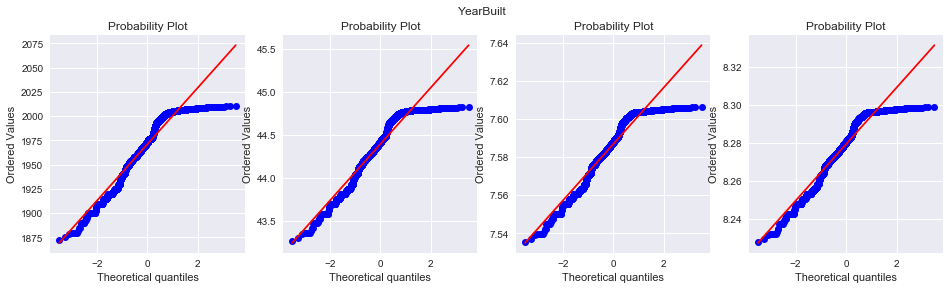

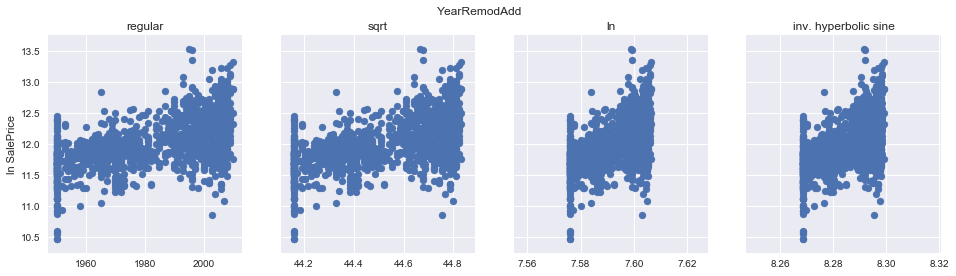

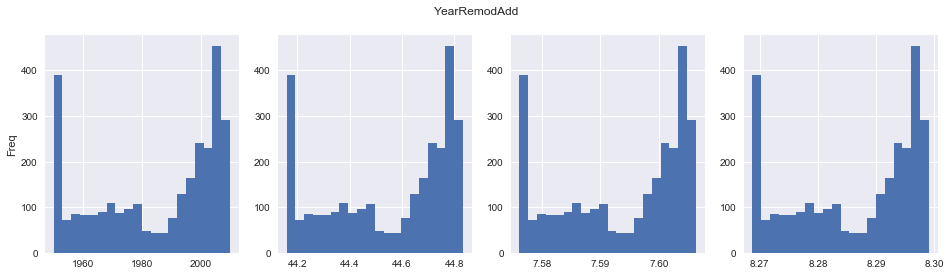

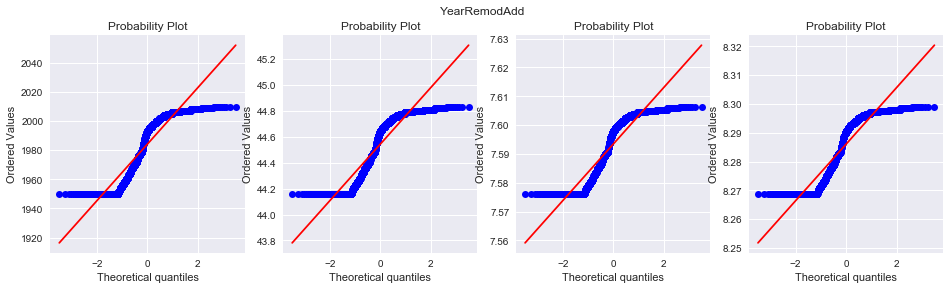

In [222]:
for col in num_cols:
    fig, (l, ml, mr, r) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True)
    ln_sp = np.log(df[COL_Y])
    
    cvals = df[col].fillna(0)
    ln_cvals = np.log(cvals + 1)
    sqrt_cvals = np.sqrt(cvals)
    ihs_cvals = np.log(cvals + np.sqrt((cvals ** 2 + 1)))
    
    l.scatter(cvals, ln_sp)
    l.set_title("regular")
    l.set_ylabel("ln SalePrice")
    ml.scatter(sqrt_cvals, ln_sp)
    ml.set_title("sqrt")
    mr.scatter(ln_cvals, ln_sp)
    mr.set_title("ln")
    r.scatter(ihs_cvals, ln_sp)
    r.set_title("inv. hyperbolic sine")
    fig.suptitle(col)
    
    fig, (l, ml, mr, r) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
    l.hist(cvals, bins=20)
    l.set_ylabel("Freq")
    ml.hist(sqrt_cvals, bins=20)
    mr.hist(ln_cvals, bins=20)
    r.hist(ihs_cvals, bins=20)
    fig.suptitle(col)
    
    fig, (l, ml, mr, r) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
    stats.probplot(cvals, dist="norm", plot=l)
    stats.probplot(sqrt_cvals, dist="norm", plot=ml)
    stats.probplot(ln_cvals, dist="norm", plot=mr)
    stats.probplot(ihs_cvals, dist="norm", plot=r)
    fig.suptitle(col)
    plt.show()

### Conclusions

A couple of outliers! Will check them out in more detail soon.

#### log transform
- 1stFlrSF: log 
- LotFrontage: log 
- GrLivArea: log
- LotArea: log
- LotFrontage: log

#### Sqrt
- MasVnrArea
- OpenPorchSF
- TotalBsmtSF
- WoodDeckSF

#### Delete
- 3SsnPorch: delete, very few values
- BsmtFinSF2: delete, very few values and not much of a correlation. Also delete BsmtFinType2.
- EnclosedPorch: delete, very few values
- LowQualFinSF: delete, very few values
- MiscVal: delete, very few values and mostly halfway in terms of SalePrice
- ScreenPorch: delete, very few values

#### Nothing/unsure
- GarageArea: nothing
- YearBuilt: nothing
- GarageYrBuilt: nothing... but the distribution looks a bit useless...
- 2ndFlrSF: TBD
- BsmtFinSF1: TBD
- BsmtUnfSF: TBD
- YearRemodAdd: nothing

### Ok, previous analysis showed a bunch of outliers. Let's isolate them.
- GarageYrBlt: One garage is built in 2200! Nice, from the future.
- GrLivArea: The relation is mostly linear but there's two that are huge with an average SalePrice.
- TotalBsmtSF: 1 value > 6000 with medium sale price.
- LotFrontage: 2 records with value ~ 300
- OpenPorchSF: 1 value > 300 but with very low saleprice. 

The approach I'm taking is: simply deleting them! Since we're using the KNN imputation algorithm, we'll fill in a new value from the most similar houses out of the entire set.

In [223]:
v = df['GarageYrBlt']
v[v > 2100]

Id
2593    2207.0
Name: GarageYrBlt, dtype: float64

In [224]:
v = df[['GrLivArea', 'SalePrice']]
v[v['GrLivArea'] > 4000]

GrLivArea  SalePrice
Id                        
524        4676   184750.0
692        4316   755000.0
1183       4476   745000.0
1299       5642   160000.0
2550       5095        NaN

In [225]:
df.loc[(524, 1299), 'GrLivArea']

Id
524     4676
1299    5642
Name: GrLivArea, dtype: int64

In [226]:
df[df['TotalBsmtSF'] > 6000][['TotalBsmtSF', 'SalePrice']]

TotalBsmtSF  SalePrice
Id                          
1299       6110.0   160000.0

Hey, same Id as before! Maybe we're better off deleting the entire record...

In [227]:
df[df['LotFrontage'] > 300][['LotFrontage', 'SalePrice']]

LotFrontage  SalePrice
Id                          
935         313.0   242000.0
1299        313.0   160000.0

In [228]:
df[df['OpenPorchSF'] > 300][['OpenPorchSF', 'SalePrice']].head(5)

OpenPorchSF  SalePrice
Id                         
496          523    34900.0
524          406   184750.0
584          502   325000.0
646          312   143250.0
736          341   163000.0

496 has a very low sale price.

### Outliers, take 2
I came back to the plots a bit later and found a couple more:

    BsmtFinSF1: delete > 4000
    1stFlrSF: delete > 2500 (x4)
    2ndFlrSF: delete ~1750 and ln(SP) ~ 12.5
    TotalBsmtSF: 1 value > 3000 with medium SP
    GrLivArea: 3 or so houses with ln(SP) ~ 10.5 but GrLivArea > 800
    GarageArea: area > 1000 but low SP (4x)
    LotArea: values > 100.000
    LottFrontage: 1 with ~ 150 but saleprice < ln(11)
    MasVnrArea: 1 with value > 1500
    OpenPorchSF: 1 with value > 500 but low saleprice

Removing these made me go from top 8% to top 5%...

In [229]:
df.loc[df['BsmtFinSF1'] > 4000, 'BsmtFinSF1']

Id
1299    5644.0
2550    4010.0
Name: BsmtFinSF1, dtype: float64

In [230]:
df.loc[df['1stFlrSF'] > 2700, ['1stFlrSF', 'SalePrice']]

1stFlrSF  SalePrice
Id                       
497       3228   430000.0
524       3138   184750.0
1025      2898   287000.0
1299      4692   160000.0
2189      3820        NaN
2550      5095        NaN
2574      2726        NaN

In [231]:
df.loc[(df['1stFlrSF'] > 2700) & (df[COL_Y].isnull() == False), ['1stFlrSF', 'SalePrice']]

1stFlrSF  SalePrice
Id                       
497       3228   430000.0
524       3138   184750.0
1025      2898   287000.0
1299      4692   160000.0

In [232]:
df.loc[(df['2ndFlrSF'] > 1750) & (df[COL_Y] < 300000), ['2ndFlrSF', 'SalePrice']]

2ndFlrSF  SalePrice
Id                      
305      1818   295000.0

In [233]:
df.loc[(df['TotalBsmtSF'] > 3000) & (df[COL_Y] < 200000), ['TotalBsmtSF', 'SalePrice']]

TotalBsmtSF  SalePrice
Id                          
524        3138.0   184750.0
1299       6110.0   160000.0

In [234]:
df.loc[(df['GarageArea'] > 1200) & (df[COL_Y] < np.exp(12.5)), ['GarageArea', 'SalePrice']]

GarageArea  SalePrice
Id                         
582       1390.0   253293.0
1062      1248.0    81000.0
1191      1356.0   168000.0
1299      1418.0   160000.0

In [235]:
df.loc[(df['LotArea'] > 100000), ['LotArea', 'SalePrice']]

LotArea  SalePrice
Id                     
250   159000   277000.0
314   215245   375000.0
336   164660   228950.0
707   115149   302000.0

In [236]:
df.loc[(df['LotFrontage'] > 140) & (df['LotFrontage'] < 160) & (df[COL_Y] < np.exp(11)), 
       ['LotFrontage', 'SalePrice']]

LotFrontage  SalePrice
Id                          
1338        153.0    52500.0

In [237]:
df.loc[(df['MasVnrArea'] > 1500), ['MasVnrArea', 'SalePrice']]

MasVnrArea  SalePrice
Id                        
298      1600.0   239000.0

In [238]:
df.loc[(df['OpenPorchSF'] > 500) & (df[COL_Y] < 50000), ['OpenPorchSF', 'SalePrice']]

OpenPorchSF  SalePrice
Id                         
496          523    34900.0

### Fireplaces
The last highly correlated numeric value that we didn't look into yet.

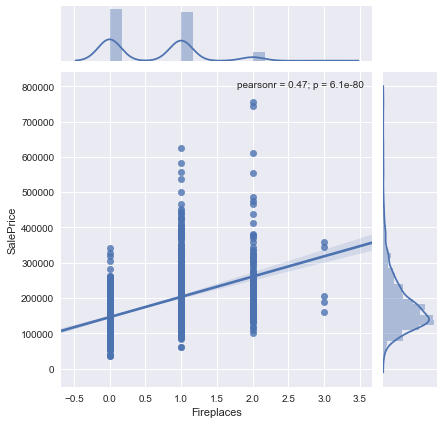

0  missing entries


In [239]:
data_profile(df, 'Fireplaces')

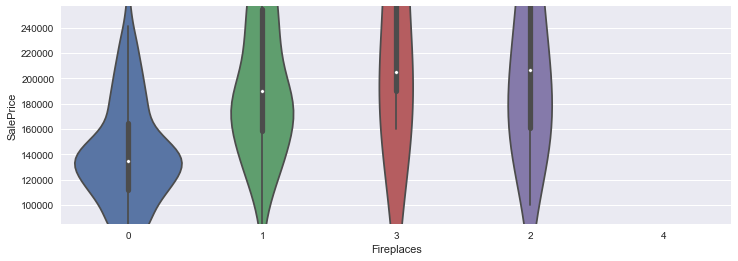

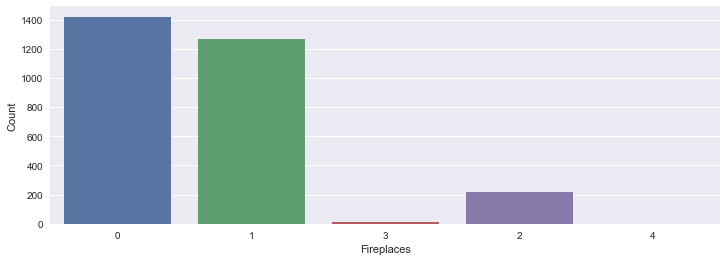

0  missing entries


In [240]:
data_profile(df, 'Fireplaces', dtype='cat')

Interesting. So having a fireplace is defnitely a good thing. Two also seems slightly better than one. There isn't enough data to really draw a conclusion about 3 or 4 fireplaces. There is definitely a relation with SalePrice, but it's not linear. Something tells me it's better to one-hot-encode this as: 1+ Fireplace, 2+ Fireplaces.

# Quality metrics
Last one. There's a whole bunch of quality metrics that have values like "Go", "Po", "Ex" etc., for Good, Poor and Excellent. I haven't done an exhaustive analysis here (yet); for now I'm assuming that it makes sense to keep the ordering here and turn them from categorical string-based variables into a numeric value with values 0, 1, 2, 3, 4, etc. I'm not 100% sure if this makes sense, because that forces a linear relationship for the linear model with SalePrice. I expect it to work well for decision trees though.

I could be totally wrong about this - that's why I'm testing the performance of all transformations.

Example:

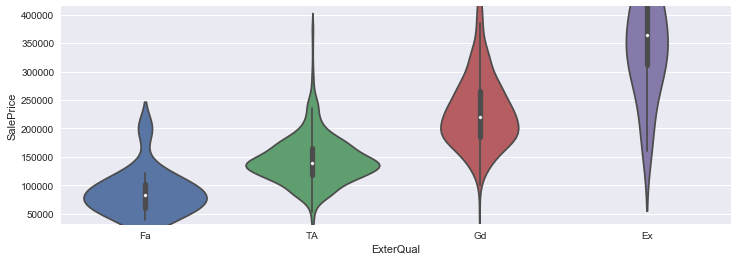

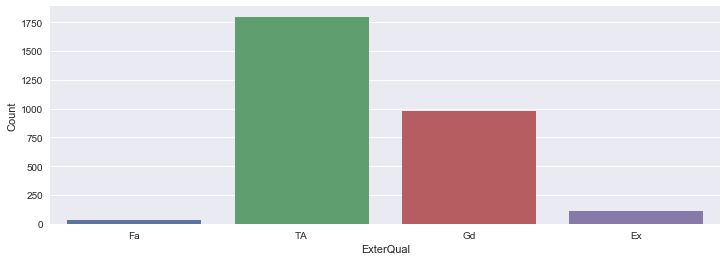

0  missing entries


In [241]:
data_profile(df, 'ExterQual')

This will get encoded as follows: Fa = 0, TA = 1, Gd = 2, Ex = 3. I'm using the median SalePrice as an ordering metric to avoid having to manually encode the ordering for each column. (There's a slight variation in the actual strings used across the columns). If a column contains missing values, it's also included in the ordering.